In [1]:
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

from sklearn.preprocessing import LabelEncoder

In [2]:
import torch
from model_common import *

In [3]:
!nvidia-smi

Mon Nov 29 18:23:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_chroma.pkl')
gpu, cpu = get_devices()

In [5]:
class ChromaMatrixDataset(AbsDataset):
    def __init__(self, labels, chromas):
        super().__init__()
        self.labels = labels
        self.chromas = chromas

    def __get__(self,index):
      if self.chromas[index].shape[1] < 1876:
        self.chromas[index] = torch.hstack((self.chromas[index],torch.zeros(12,1876-self.chromas[index].shape[1])))
      return self.chromas[index].reshape((1,)+self.chromas[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['chroma'].iloc[x] for x in train_ids]
      test_vals = [data['chroma'].iloc[x] for x in test_ids]
      train_data = ChromaMatrixDataset(train_lbls, train_vals)
      test_data = ChromaMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [6]:
class ChromaRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1,2), padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(1,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.final = nn.Sequential(nn.Linear(5628,1000),nn.ReLU(),nn.Linear(1000,n_labels))
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

In [7]:
ragam_te_to_en = {
    'సామంతం' : 'Samantham',
    'దేసాళం' : 'Desalam',
    'రామక్రియ' : 'Ramakriya',
    'కన్నడగౌళ' : 'Kannadagowla',
    'శంకరాభరణం' : 'Sankarabharanam',
    'దేవగాంధారి' : 'Devagandhari',
    'ఆహిరి' : 'Aahiri',
    'ముఖారి' : 'Mukhari',
    'నాట' : 'Naata',
    'శుద్ధవసంతం' : 'Suddavasantham',
    'సాళంగనాట' : 'Salanganata',
    'లలిత' : 'Lalitha',
    'భూపాలం' : 'Bhupalam',
    'ధన్నాసి' : 'Dhannasi',
    'కాంబోది' : 'Kambodhi',
    'బౌళి' : 'Bauli',
    'గుండుక్రియ' : 'Gundukriya',
    'శ్రీరాగం' : 'Sriragam',
    'భైరవి' : 'Bhairavi',
    'పాడి' : 'Paadi',
    'మాళవి' : 'Maalavi',
    'నాదరామక్రియ' : 'Nadaramakriya',
    'మలహరి' : 'Malahari',
    'వరాళి' : 'Varali',
    'గౌళ' : 'Gowla',
    'సాళంగం' : 'Salangam',
    'బౌళిరామక్రియ' : 'Bauliramakriya',
    'మాళవిగౌళ' : 'Malavigowla',
    'గుజ్జరి' : 'Gujjari',
    'దేసాక్షి' : 'Desakshi'
}

In [8]:
data['Ragam'].replace(ragam_te_to_en,inplace=True)

In [9]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='chroma', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2, nindex_factor=None):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    
    if nindex_factor:
      np.random.seed(42)
      ndata = pd.DataFrame()
      ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
      ndata[feature] = data[feature]
      pindex = ndata[ndata[target]==1].index
      nindex = ndata[ndata[target]==0].index
      index = np.random.choice(pindex,pindex.shape[0]).tolist() + np.random.choice(nindex,nindex_factor*pindex.shape[0]).tolist()
      tdata = ndata.loc[index]
    else:
      tdata = pd.DataFrame()
      tdata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
      tdata[feature] = data[feature]

    
    results[i] = train_model(tdata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : f'{title} - {lbl}',
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['Aahiri'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 216/54
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.766 / Validation Loss : 0.637 [Time : 0.382907 seconds]
Epoch 2/15 : Training Loss: 0.477 / Validation Loss : 0.673 [Time : 0.055617 seconds]
Epoch 3/15 : Training Loss: 0.481 / Validation Loss : 0.717 [Time : 0.051755 seconds]
Epoch 4/15 : Training Loss: 0.501 / Validation Loss : 0.730 [Time : 0.051792 seconds]
Epoch 5/15 : Training Loss: 0.512 / Validation Loss : 0.722 [Time : 0.05586 seconds]
Epoch 6/15 : Training Loss: 0.513 / Validation Loss : 0.709 [Time : 0.050076 seconds]
Epoch 7/15 : Training Loss: 0.510 / Validation Loss : 0.698 [Time : 0.049563 seconds]
Epoch 8/15 : Training Loss: 0.508 / Validation Loss : 0.690 [Time : 0.050304 seconds]
Epoch 9/15 : Training Loss: 0.505 / Validation Loss : 0.687 [Time : 0.052112 seconds]
Epoch 10/15 : Training Loss: 0.504 / Validation Loss : 0.686 [Time : 0.052124 seconds]
Epoch 11/15 : Training 

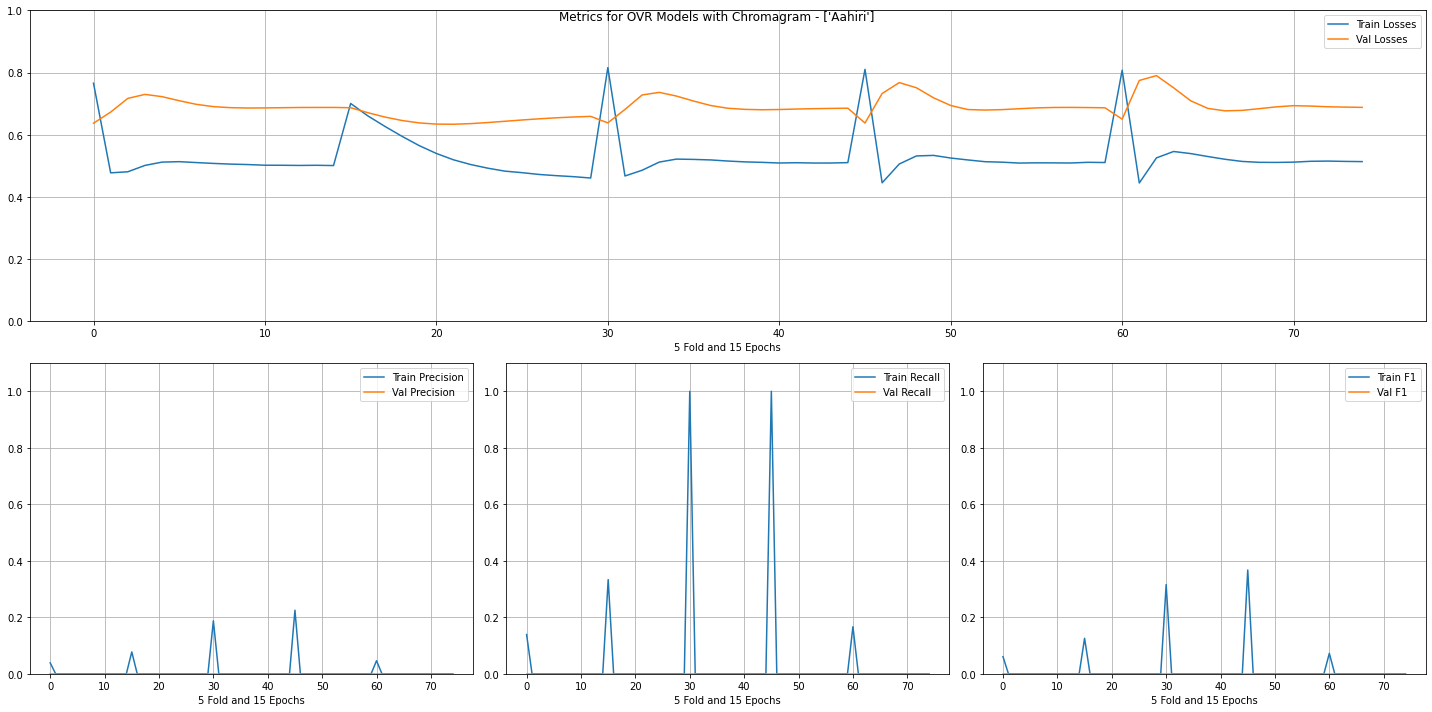

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.367347            0.0  ...      0.810375           0.637536
0   0.315789            0.0  ...      0.815921           0.638148
0   0.125654            0.0  ...      0.700538           0.686872
0   0.072289            0.0  ...      0.807619           0.650129
0   0.060606            0.0  ...      0.765726           0.637067
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.511775           0.693450
11  0.000000            0.0  ...      0.514525           0.692155
12  0.000000            0.0  ...      0.515165           0.689918
13  0.000000            0.0  ...      0.514131           0.688850
14  0.000000            0.0  ...      0.513487           0.687985

[75 rows x 12 columns]
Training for ['Bauli'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.795 / Validation Loss : 0.693 [Time : 0

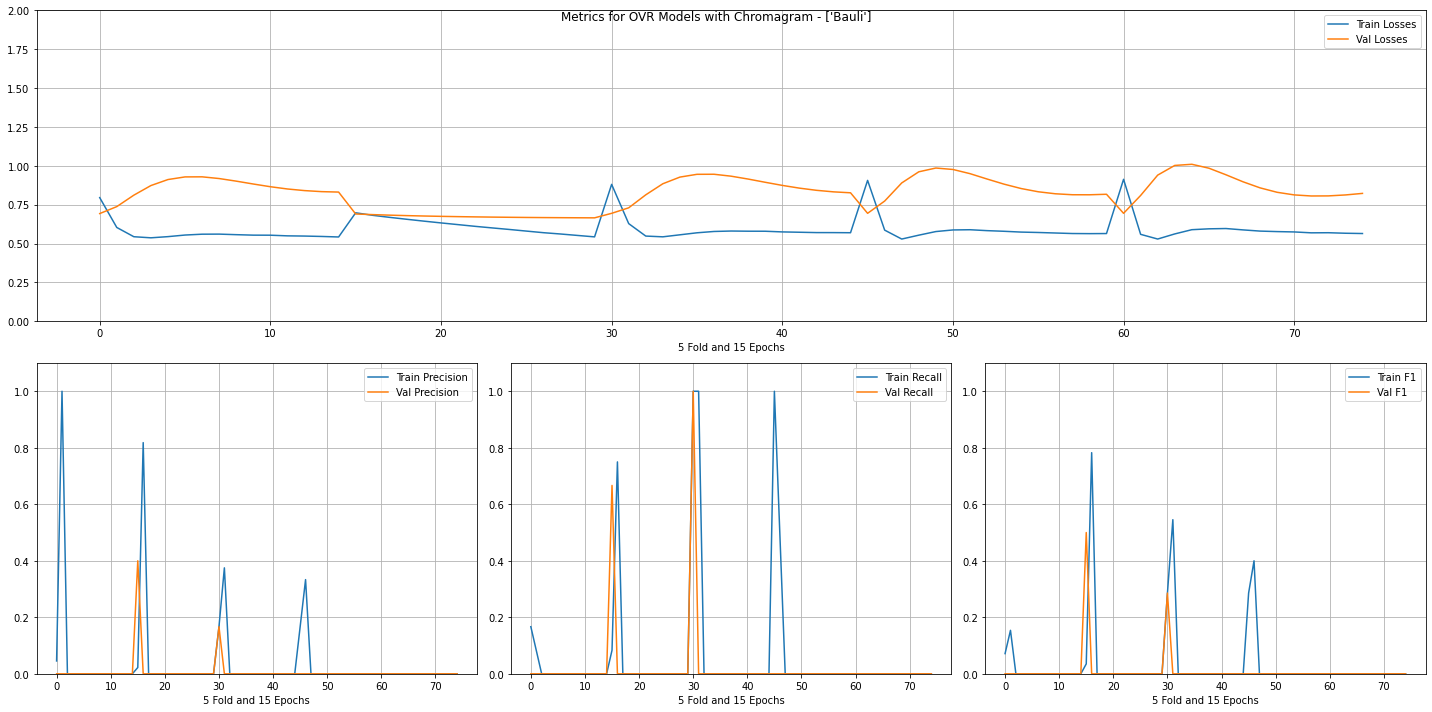

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.035088       0.500000  ...      0.697543           0.689858
0   0.285714       0.285714  ...      0.880472           0.694156
1   0.782609       0.000000  ...      0.681286           0.685870
1   0.545455       0.000000  ...      0.627970           0.729696
1   0.400000       0.000000  ...      0.586066           0.773070
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.574379           0.812706
11  0.000000       0.000000  ...      0.568685           0.805796
12  0.000000       0.000000  ...      0.569360           0.806323
13  0.000000       0.000000  ...      0.565997           0.812436
14  0.000000       0.000000  ...      0.564197           0.822389

[75 rows x 12 columns]
Training for ['Bauliramakriya'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 91/23
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.806 / Validation Loss : 0.691 

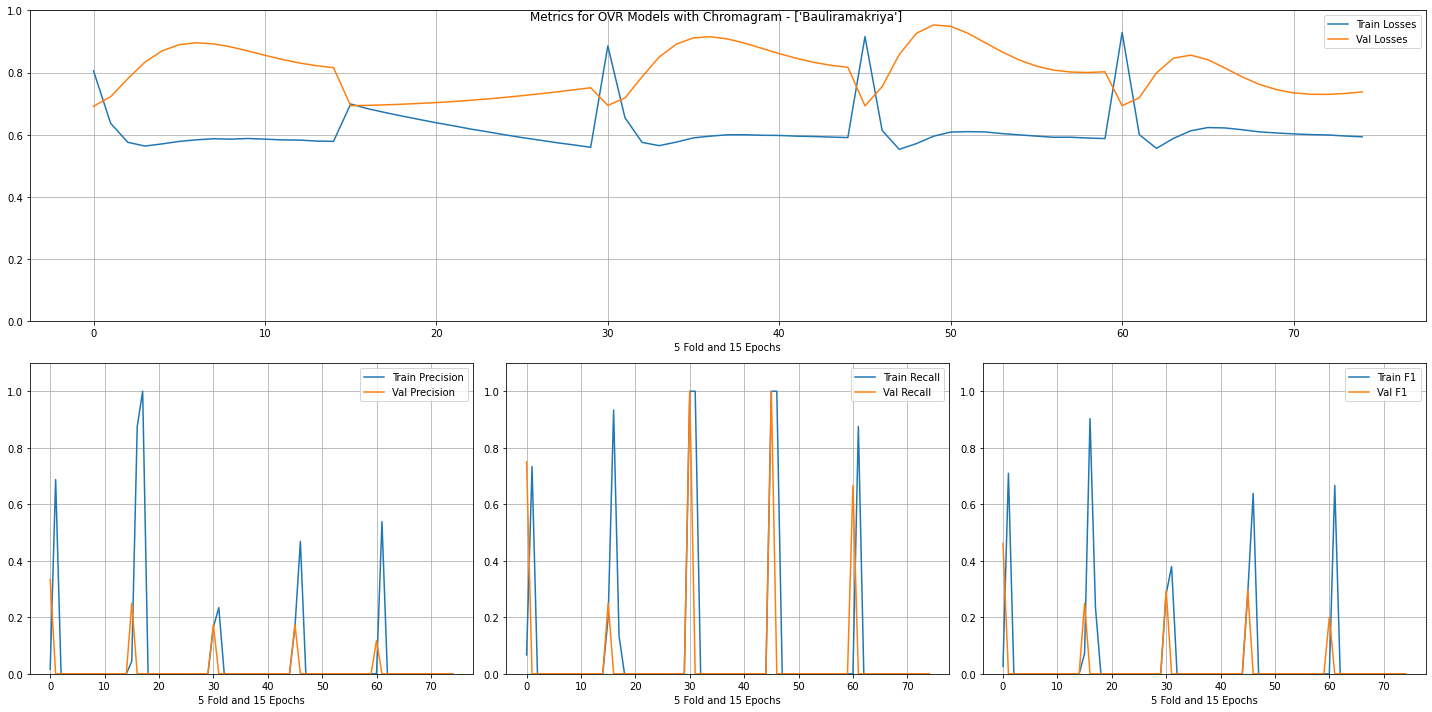

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.025974       0.461538  ...      0.805541           0.691413
0   0.283019       0.296296  ...      0.885724           0.694403
0   0.283019       0.296296  ...      0.915703           0.692836
0   0.072289       0.250000  ...      0.698890           0.693386
0   0.000000       0.200000  ...      0.928999           0.693398
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.602774           0.734739
11  0.000000       0.000000  ...      0.600386           0.730116
12  0.000000       0.000000  ...      0.599253           0.729777
13  0.000000       0.000000  ...      0.595822           0.732703
14  0.000000       0.000000  ...      0.593221           0.737528

[75 rows x 12 columns]
Training for ['Bhairavi'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 134/34
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.764 / Validation Loss : 0.623 [Time

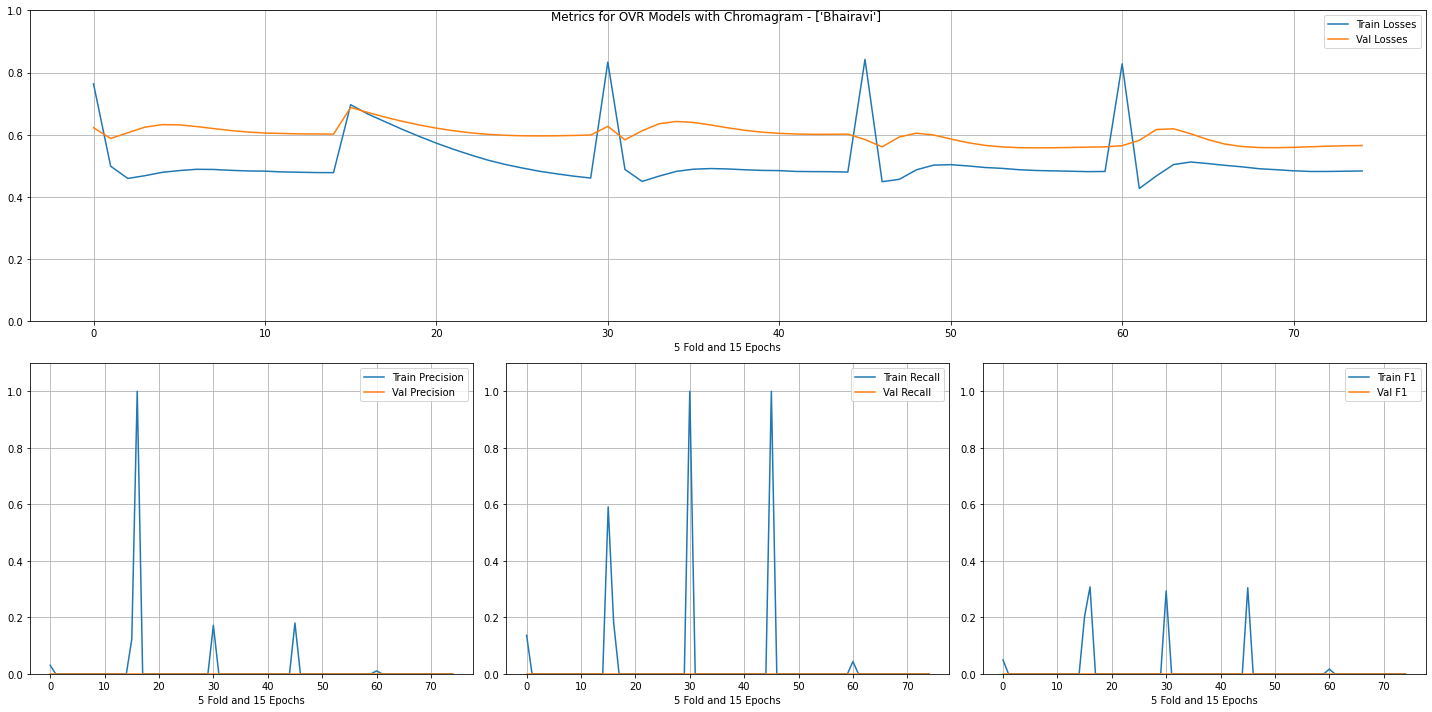

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.307692            0.0  ...      0.666762           0.671807
0   0.304636            0.0  ...      0.842258           0.584511
0   0.293333            0.0  ...      0.833675           0.626876
0   0.203125            0.0  ...      0.696580           0.687799
0   0.049180            0.0  ...      0.763719           0.622630
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.483873           0.559351
11  0.000000            0.0  ...      0.481754           0.561206
12  0.000000            0.0  ...      0.481813           0.563056
13  0.000000            0.0  ...      0.482522           0.564415
14  0.000000            0.0  ...      0.483417           0.565168

[75 rows x 12 columns]
Training for ['Bhupalam'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.800 / Validation Loss : 0.697 [Time 

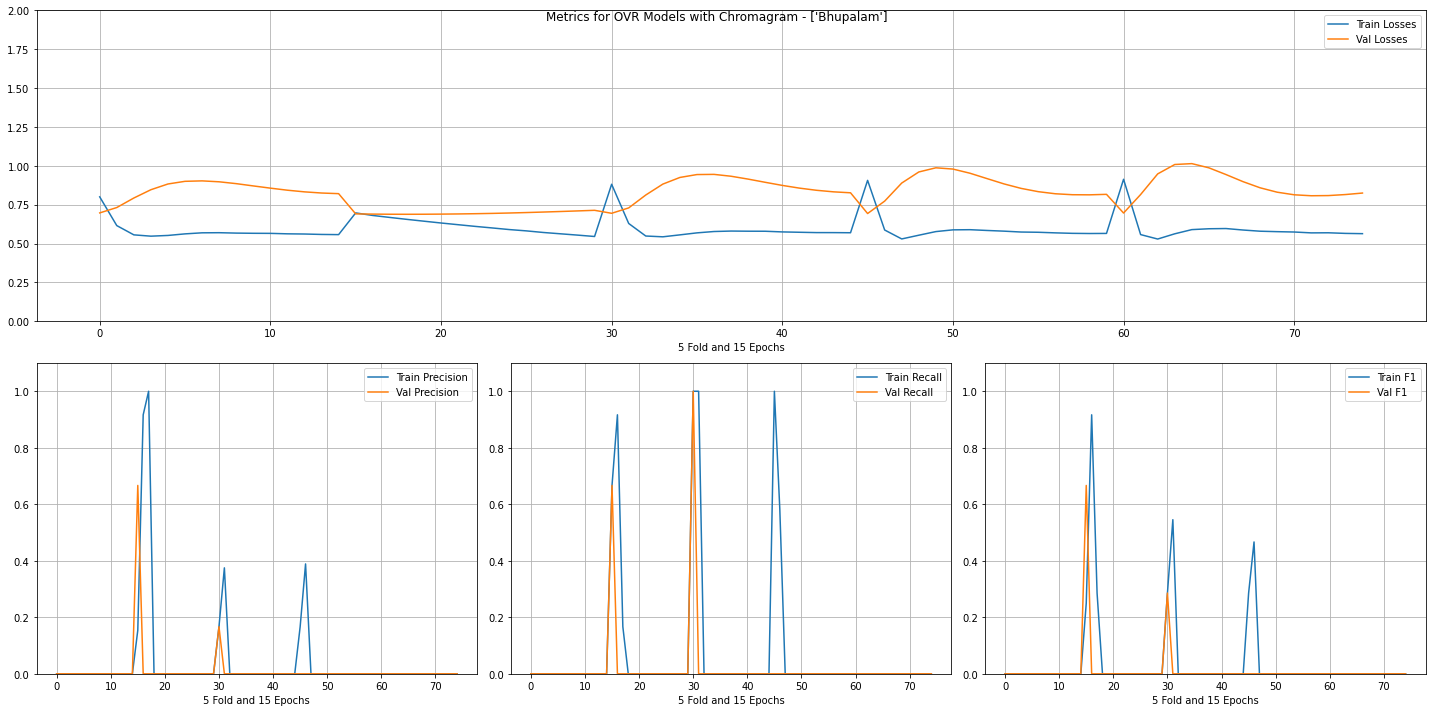

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.250000       0.666667  ...      0.696836           0.690582
0   0.285714       0.285714  ...      0.881194           0.694388
1   0.916667       0.000000  ...      0.680410           0.689166
1   0.545455       0.000000  ...      0.628853           0.729101
1   0.466667       0.000000  ...      0.586830           0.772704
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.573909           0.813420
11  0.000000       0.000000  ...      0.568349           0.807264
12  0.000000       0.000000  ...      0.568970           0.808376
13  0.000000       0.000000  ...      0.565036           0.814977
14  0.000000       0.000000  ...      0.563331           0.824636

[75 rows x 12 columns]
Training for ['Desakshi'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 67/17
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.797 / Validation Loss : 0.692 [Time 

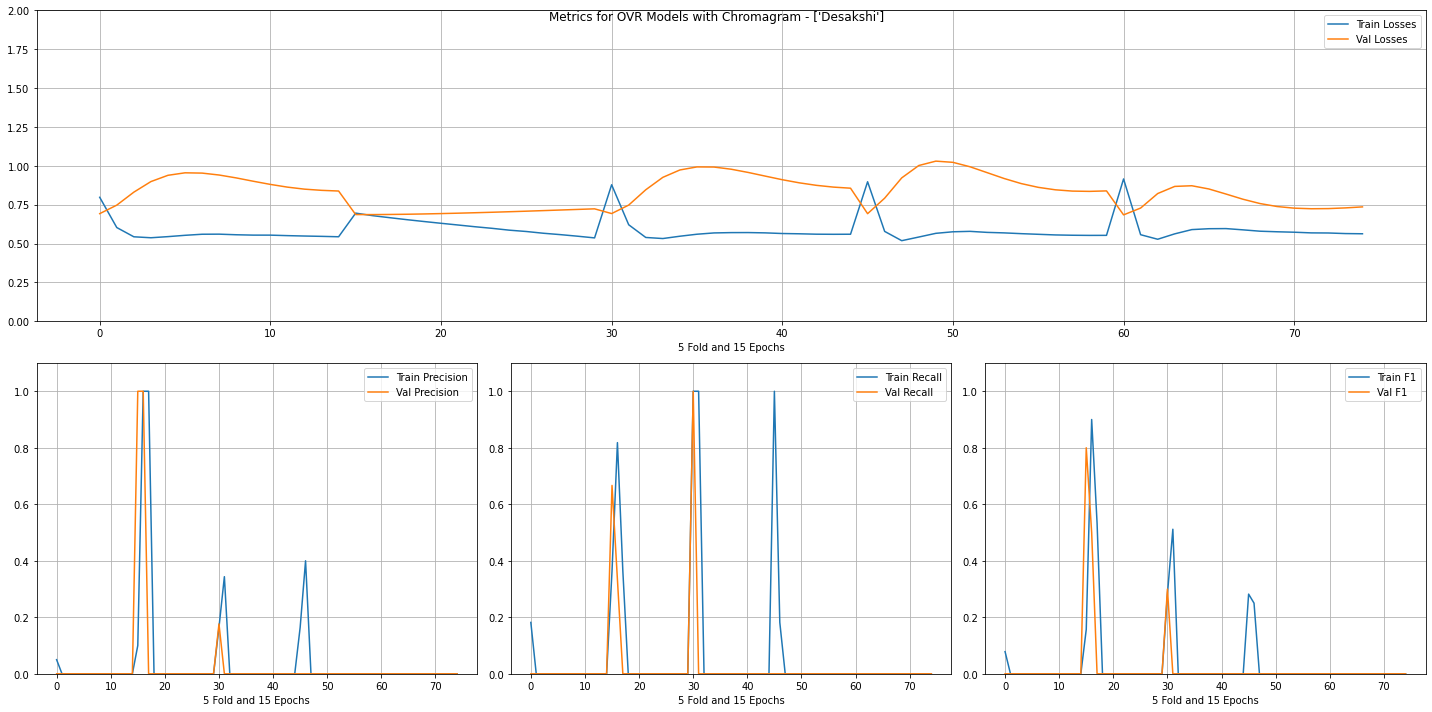

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.156863            0.8  ...      0.695411           0.686175
1   0.900000            0.5  ...      0.679070           0.686080
0   0.282051            0.3  ...      0.878027           0.692654
2   0.533333            0.0  ...      0.666033           0.686888
1   0.511628            0.0  ...      0.620580           0.747220
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.572606           0.727394
11  0.000000            0.0  ...      0.568326           0.723644
12  0.000000            0.0  ...      0.567638           0.724598
13  0.000000            0.0  ...      0.563901           0.729113
14  0.000000            0.0  ...      0.562611           0.735559

[75 rows x 12 columns]
Training for ['Desalam'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 168/42
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.736 / Validation Loss : 0.614 [Time 

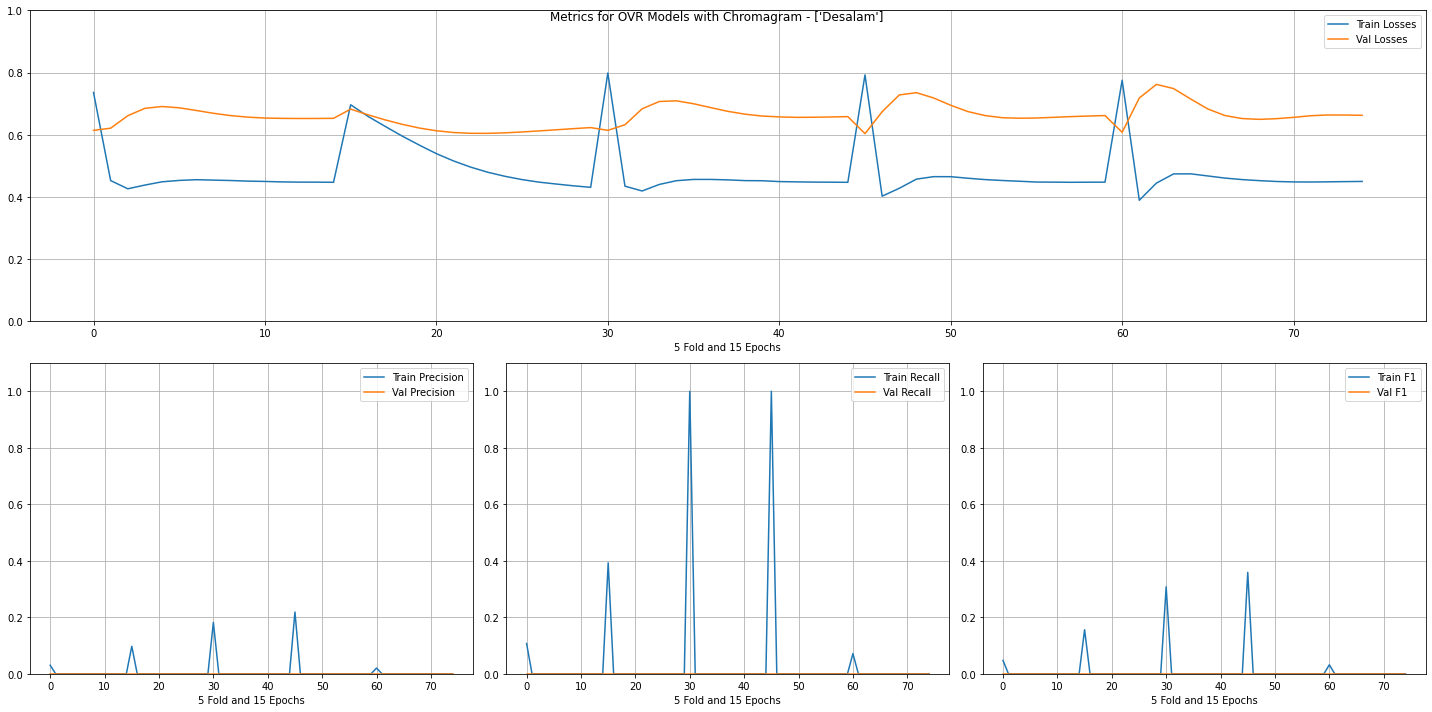

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.358974            0.0  ...      0.792428           0.603453
0   0.307692            0.0  ...      0.798505           0.613991
0   0.156028            0.0  ...      0.696367           0.682328
0   0.047244            0.0  ...      0.736043           0.614091
0   0.031746            0.0  ...      0.775416           0.607750
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.448116           0.655829
11  0.000000            0.0  ...      0.447820           0.661123
12  0.000000            0.0  ...      0.448418           0.663503
13  0.000000            0.0  ...      0.449132           0.663356
14  0.000000            0.0  ...      0.449690           0.662465

[75 rows x 12 columns]
Training for ['Devagandhari'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 139/35
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.763 / Validation Loss : 0.616 [

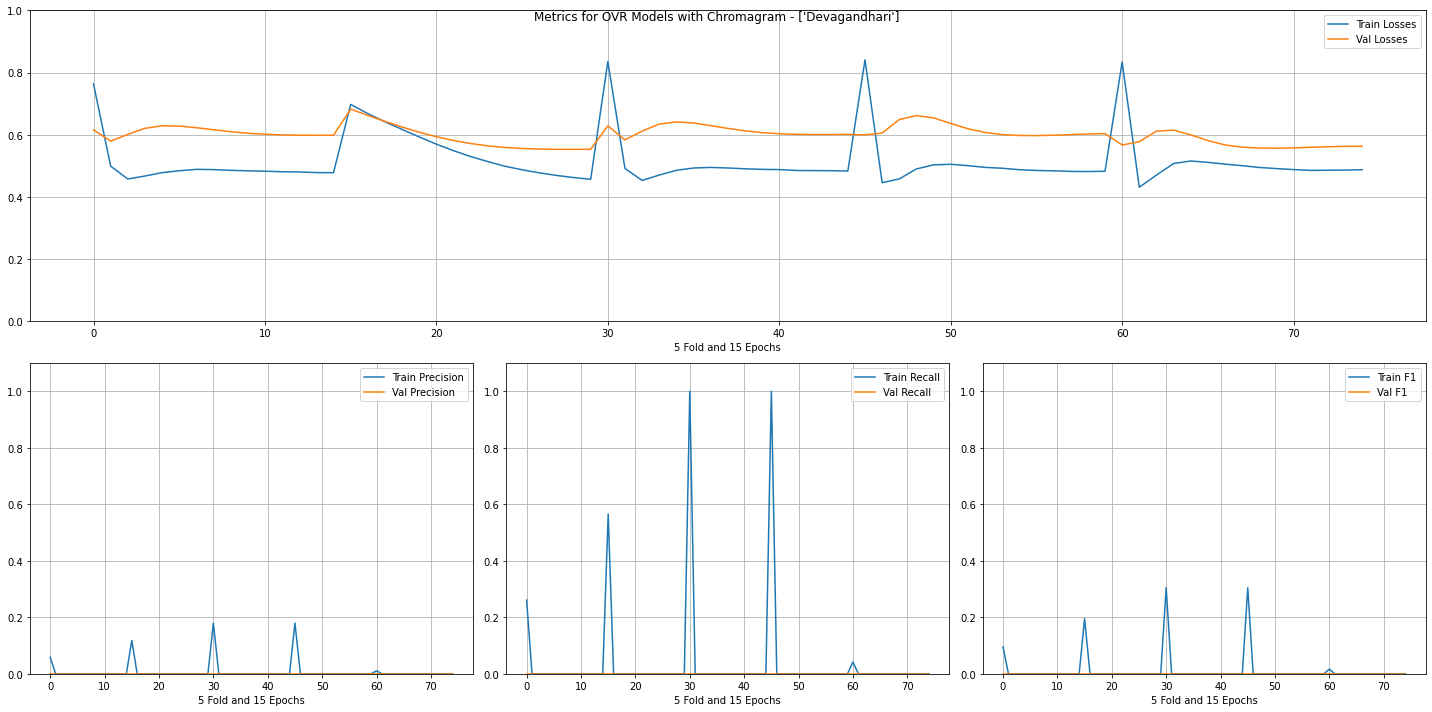

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.304636            0.0  ...      0.835732           0.628461
0   0.304636            0.0  ...      0.840811           0.599543
0   0.195489            0.0  ...      0.697557           0.682432
0   0.095238            0.0  ...      0.763486           0.615616
0   0.016529            0.0  ...      0.834313           0.566885
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.487785           0.557621
11  0.000000            0.0  ...      0.485280           0.559499
12  0.000000            0.0  ...      0.485728           0.561344
13  0.000000            0.0  ...      0.486266           0.562473
14  0.000000            0.0  ...      0.487348           0.562963

[75 rows x 12 columns]
Training for ['Dhannasi'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 192/48
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.740 / Validation Loss : 0.625 [Time

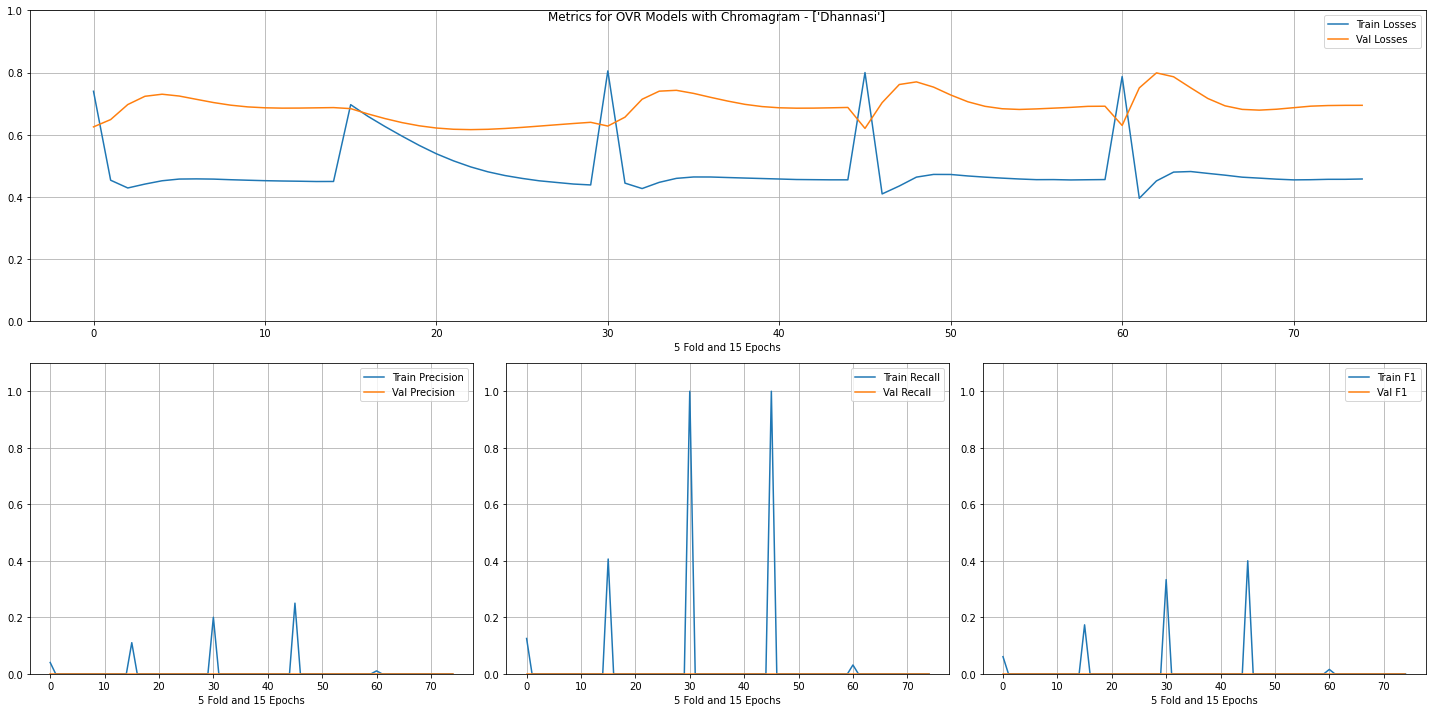

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.400000            0.0  ...      0.799950           0.620362
0   0.333333            0.0  ...      0.805333           0.627882
0   0.173333            0.0  ...      0.696750           0.683937
0   0.060606            0.0  ...      0.739722           0.625224
0   0.015504            0.0  ...      0.787171           0.629848
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.454724           0.686935
11  0.000000            0.0  ...      0.455229           0.691881
12  0.000000            0.0  ...      0.456480           0.693882
13  0.000000            0.0  ...      0.456538           0.694532
14  0.000000            0.0  ...      0.457575           0.694607

[75 rows x 12 columns]
Training for ['Gowla'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.808 / Validation Loss : 0.691 [Time : 0

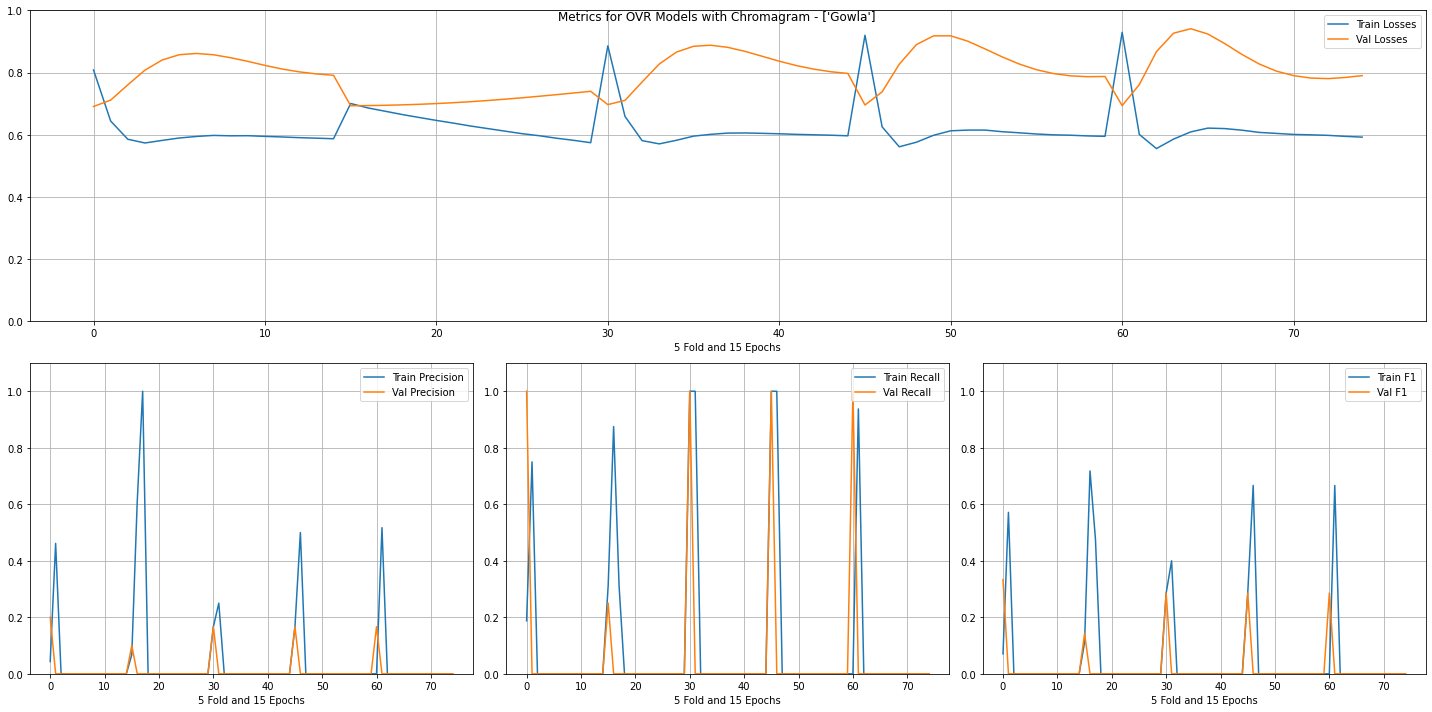

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.070588       0.333333  ...      0.808277           0.690830
0   0.285714       0.285714  ...      0.885884           0.696943
0   0.285714       0.285714  ...      0.920000           0.695627
0   0.000000       0.285714  ...      0.929418           0.693533
0   0.111111       0.142857  ...      0.700445           0.693326
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.600927           0.790097
11  0.000000       0.000000  ...      0.599622           0.782308
12  0.000000       0.000000  ...      0.598008           0.780529
13  0.000000       0.000000  ...      0.594796           0.784106
14  0.000000       0.000000  ...      0.592242           0.790125

[75 rows x 12 columns]
Training for ['Gujjari'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 120/30
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.791 / Validation Loss : 0.699 [Time 

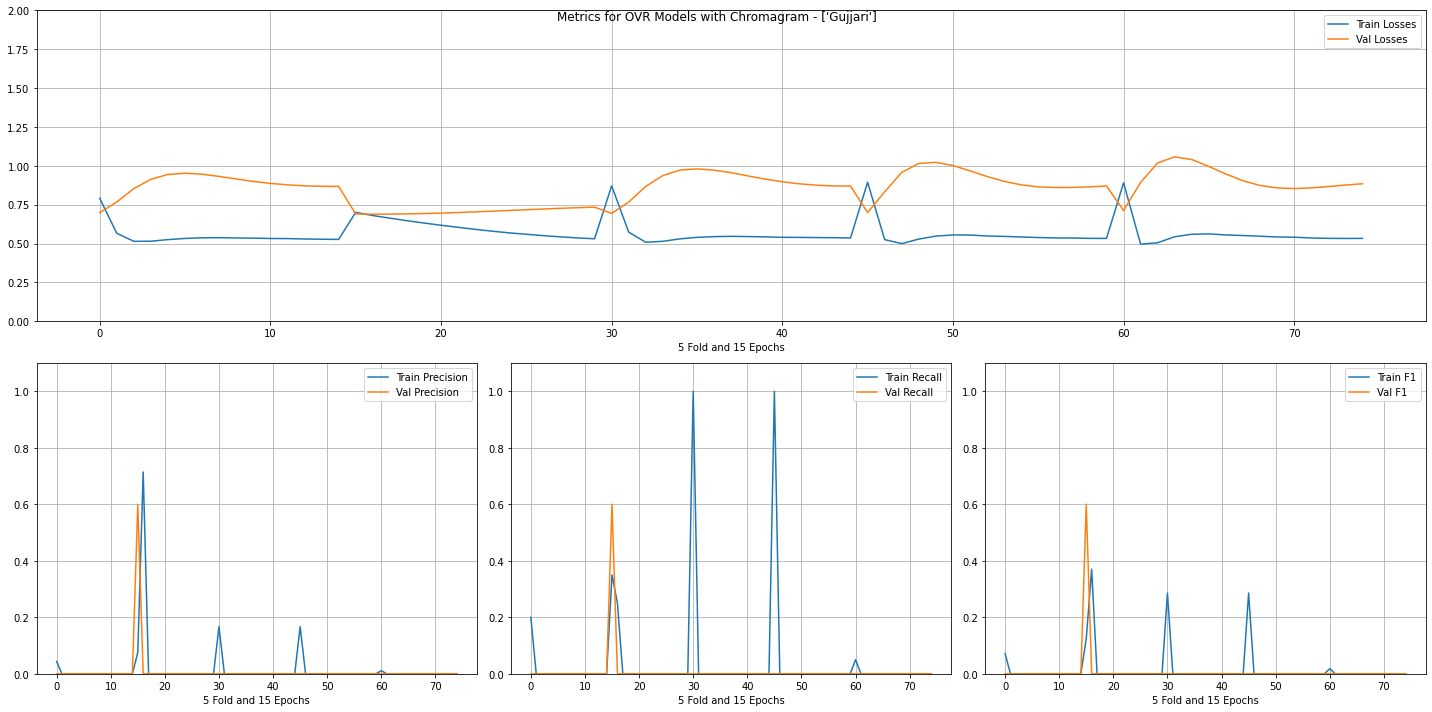

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.123894            0.6  ...      0.700481           0.690202
1   0.370370            0.0  ...      0.680010           0.688845
0   0.285714            0.0  ...      0.871156           0.693720
0   0.285714            0.0  ...      0.894005           0.699075
0   0.071429            0.0  ...      0.790897           0.698694
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.540427           0.853514
11  0.000000            0.0  ...      0.535336           0.857687
12  0.000000            0.0  ...      0.533032           0.866467
13  0.000000            0.0  ...      0.532505           0.876179
14  0.000000            0.0  ...      0.533033           0.884450

[75 rows x 12 columns]
Training for ['Gundukriya'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.790 / Validation Loss : 0.680 [Tim

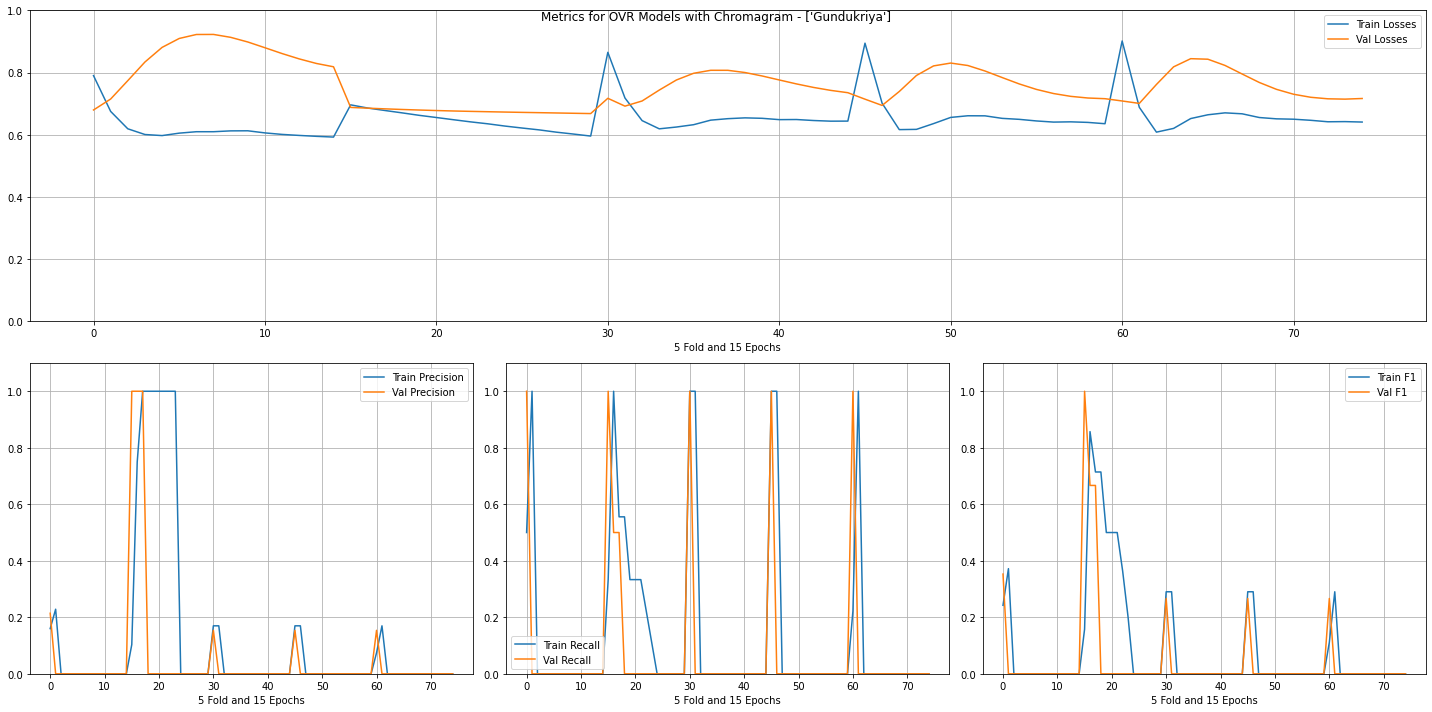

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.157895       1.000000  ...      0.696114           0.687852
1   0.857143       0.666667  ...      0.685779           0.685414
2   0.714286       0.666667  ...      0.677914           0.683221
0   0.242424       0.352941  ...      0.790161           0.679607
0   0.290323       0.266667  ...      0.865067           0.717181
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.649905           0.730213
11  0.000000       0.000000  ...      0.646383           0.720463
12  0.000000       0.000000  ...      0.641667           0.715561
13  0.000000       0.000000  ...      0.642169           0.714500
14  0.000000       0.000000  ...      0.640771           0.716559

[75 rows x 12 columns]
Training for ['Kambodhi'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 235/59
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.786 / Validation Loss : 0.644 [Time

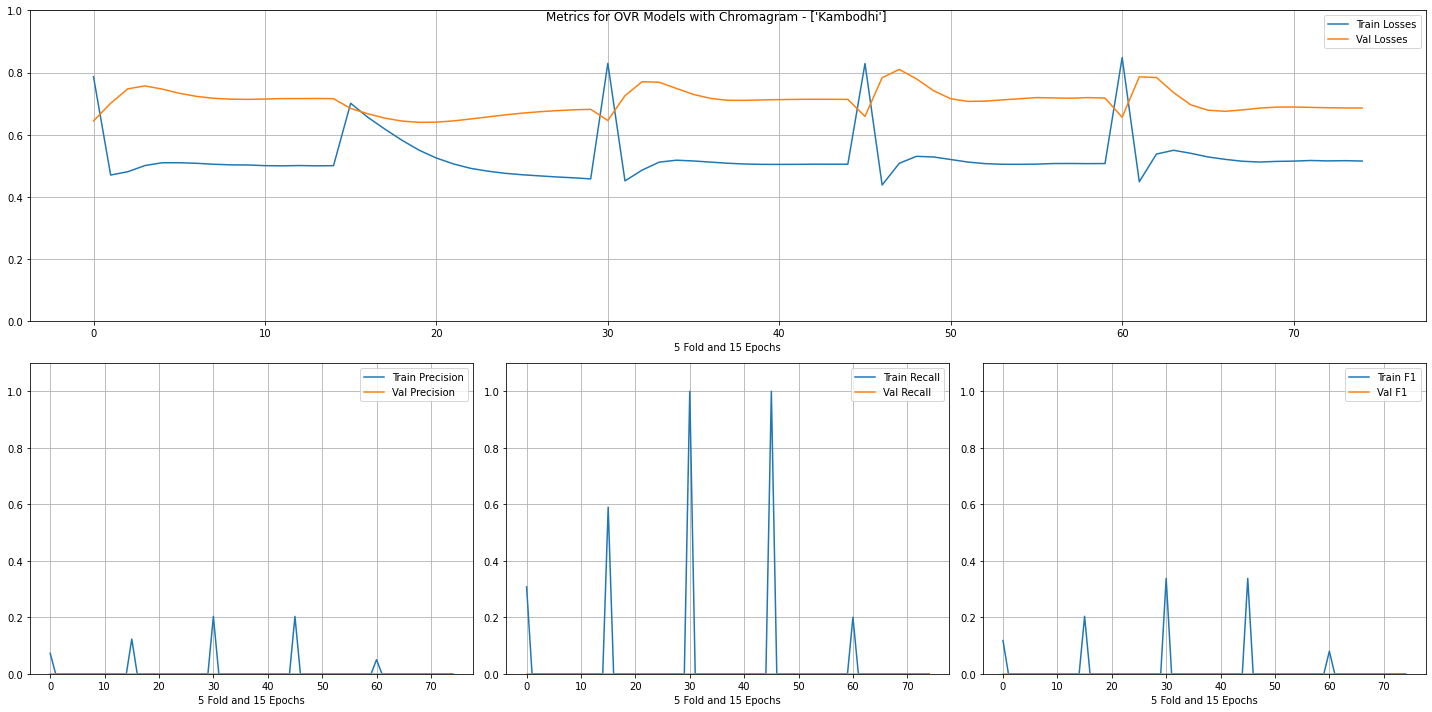

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.337662            0.0  ...      0.829554           0.645804
0   0.337662            0.0  ...      0.828965           0.658932
0   0.203540            0.0  ...      0.701181           0.684552
0   0.117647            0.0  ...      0.786411           0.644278
0   0.080000            0.0  ...      0.848136           0.656206
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.515048           0.689149
11  0.000000            0.0  ...      0.517094           0.687933
12  0.000000            0.0  ...      0.515753           0.686786
13  0.000000            0.0  ...      0.516554           0.686127
14  0.000000            0.0  ...      0.515298           0.686082

[75 rows x 12 columns]
Training for ['Kannadagowla'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 336/84
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.775 / Validation Loss : 0.584 [

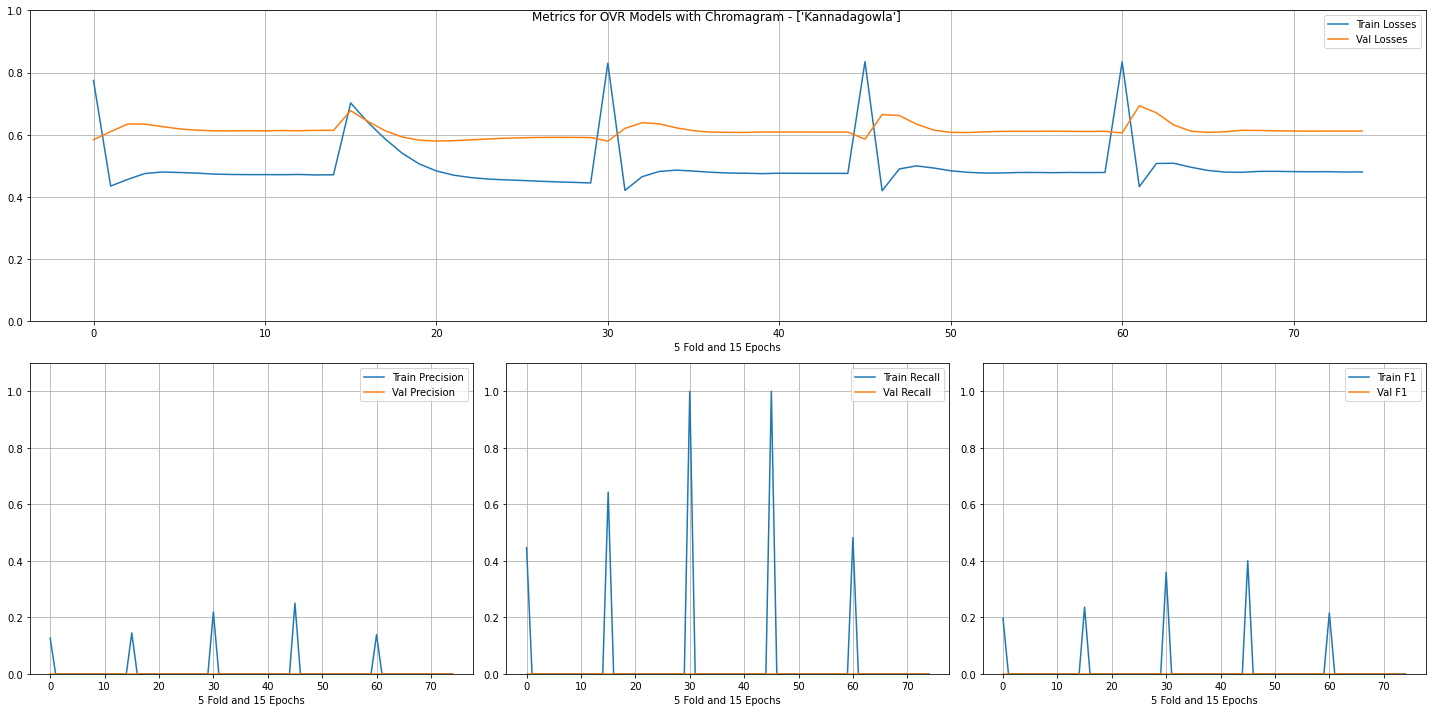

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.400000            0.0  ...      0.834978           0.585662
0   0.358974            0.0  ...      0.829928           0.579352
0   0.236066            0.0  ...      0.702197           0.677566
0   0.215139            0.0  ...      0.834431           0.605861
0   0.196078            0.0  ...      0.774617           0.583743
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.481302           0.611799
11  0.000000            0.0  ...      0.480784           0.611588
12  0.000000            0.0  ...      0.481072           0.611761
13  0.000000            0.0  ...      0.480001           0.611883
14  0.000000            0.0  ...      0.480314           0.611821

[75 rows x 12 columns]
Training for ['Lalitha'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 62/16
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.795 / Validation Loss : 0.694 [Time :

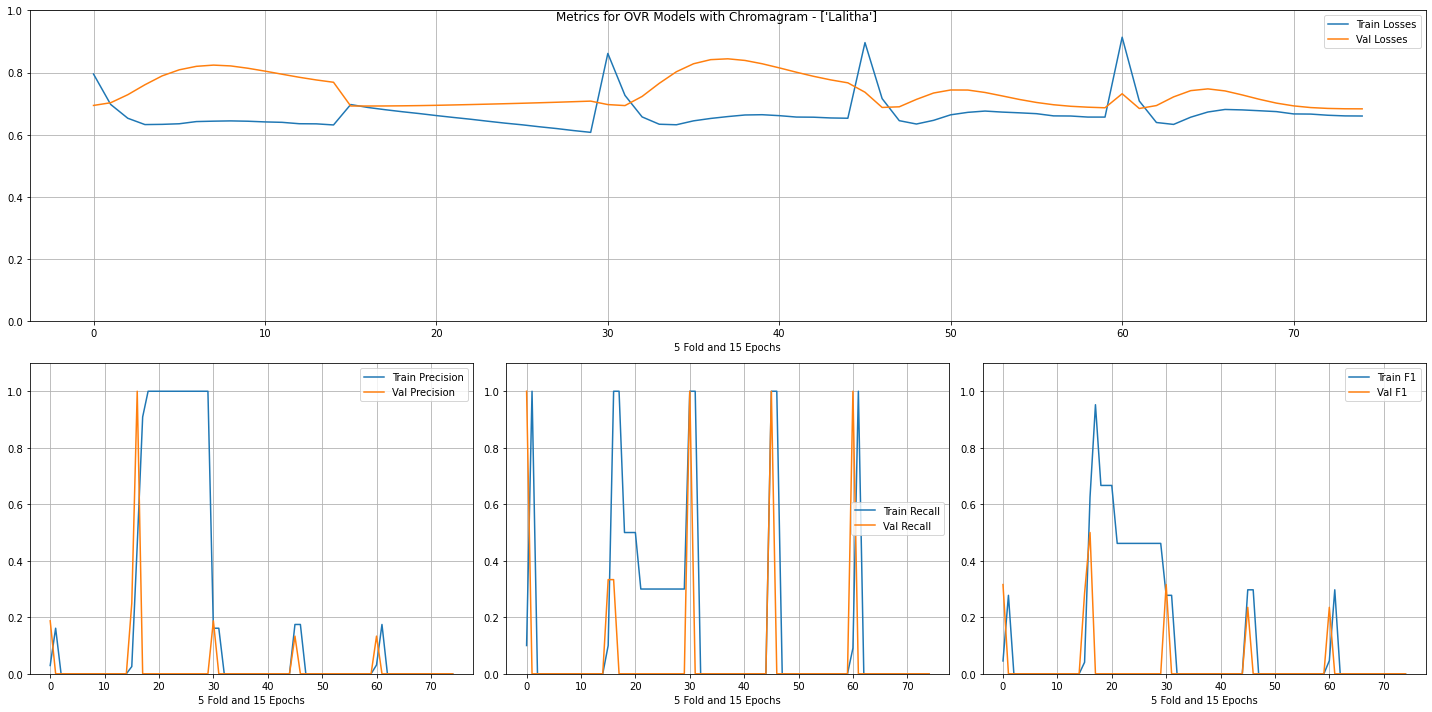

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.625000       0.500000  ...      0.687714           0.692302
0   0.277778       0.315789  ...      0.861507           0.696992
0   0.045455       0.315789  ...      0.795222           0.694223
0   0.040816       0.285714  ...      0.697109           0.692390
0   0.297297       0.235294  ...      0.896339           0.736748
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.666910           0.692788
11  0.000000       0.000000  ...      0.666378           0.687355
12  0.000000       0.000000  ...      0.662650           0.684609
13  0.000000       0.000000  ...      0.660545           0.683447
14  0.000000       0.000000  ...      0.660185           0.683236

[75 rows x 12 columns]
Training for ['Maalavi'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 153/39
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.771 / Validation Loss : 0.635 [Time 

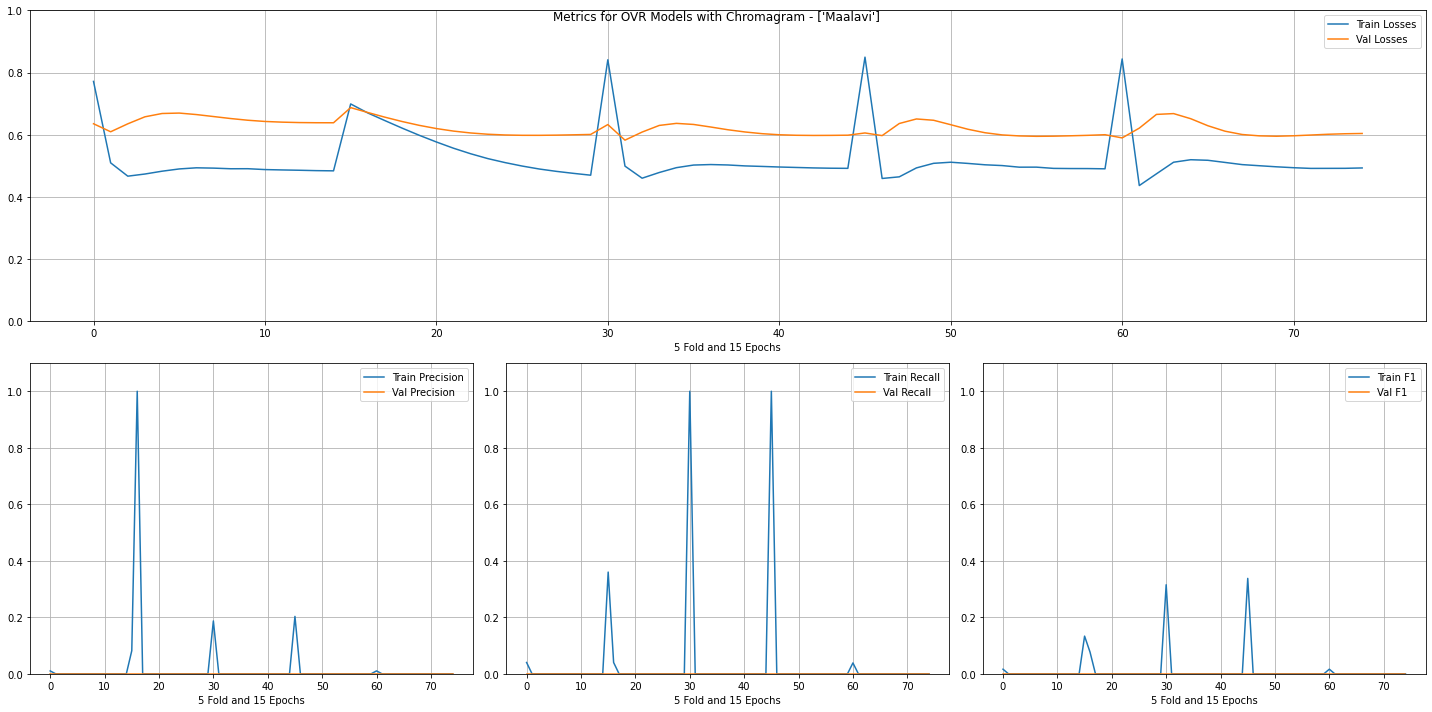

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.337662            0.0  ...      0.849588           0.605663
0   0.315152            0.0  ...      0.841117           0.632694
0   0.133333            0.0  ...      0.699025           0.687193
1   0.076923            0.0  ...      0.669963           0.671505
0   0.016260            0.0  ...      0.771461           0.635306
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.493867           0.596603
11  0.000000            0.0  ...      0.491637           0.598973
12  0.000000            0.0  ...      0.491757           0.601479
13  0.000000            0.0  ...      0.491878           0.603110
14  0.000000            0.0  ...      0.493098           0.603999

[75 rows x 12 columns]
Training for ['Malahari'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 129/33
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.757 / Validation Loss : 0.608 [Time

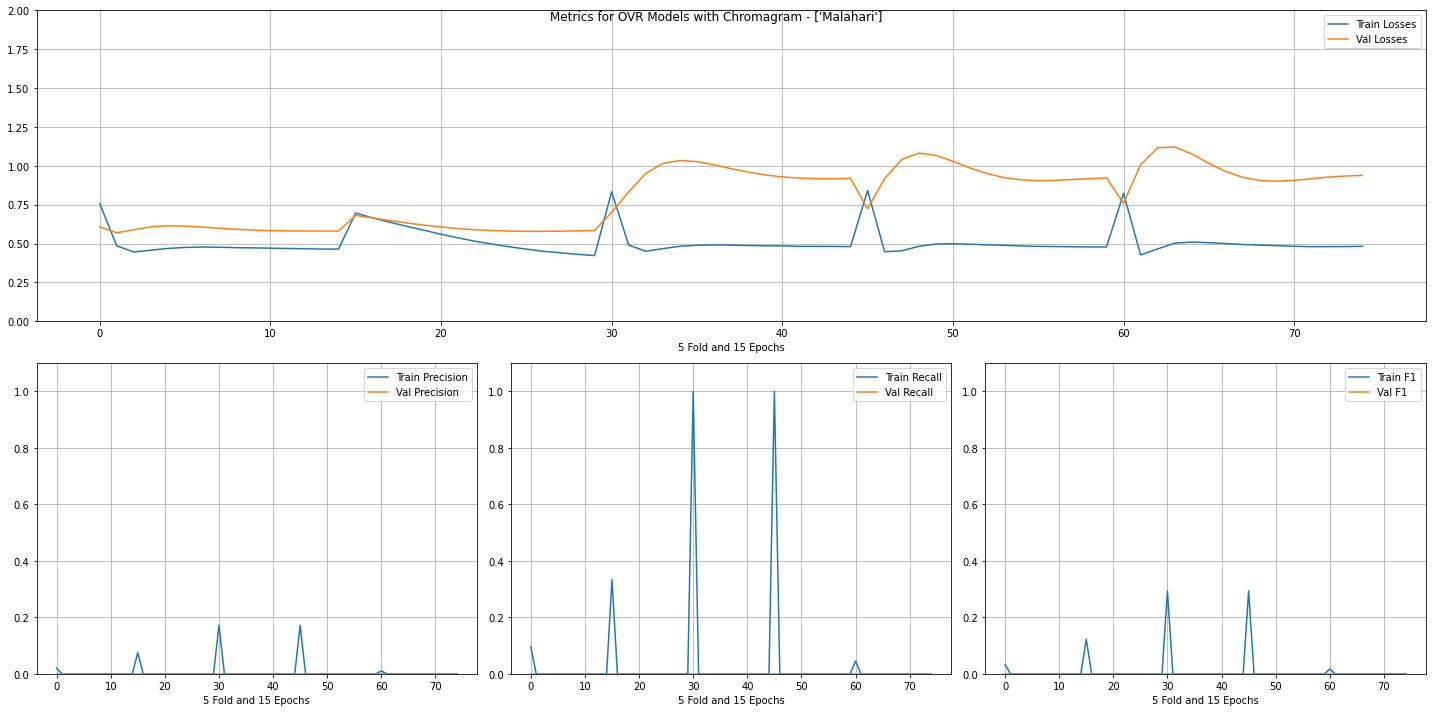

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.293333            0.0  ...      0.832897           0.701469
0   0.293333            0.0  ...      0.841697           0.722982
0   0.122807            0.0  ...      0.696269           0.681031
0   0.033058            0.0  ...      0.756774           0.607542
0   0.016667            0.0  ...      0.823303           0.759287
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.482262           0.906405
11  0.000000            0.0  ...      0.479448           0.917030
12  0.000000            0.0  ...      0.479961           0.927195
13  0.000000            0.0  ...      0.480302           0.934477
14  0.000000            0.0  ...      0.481919           0.938229

[75 rows x 12 columns]
Training for ['Malavigowla'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.809 / Validation Loss : 0.692 [Ti

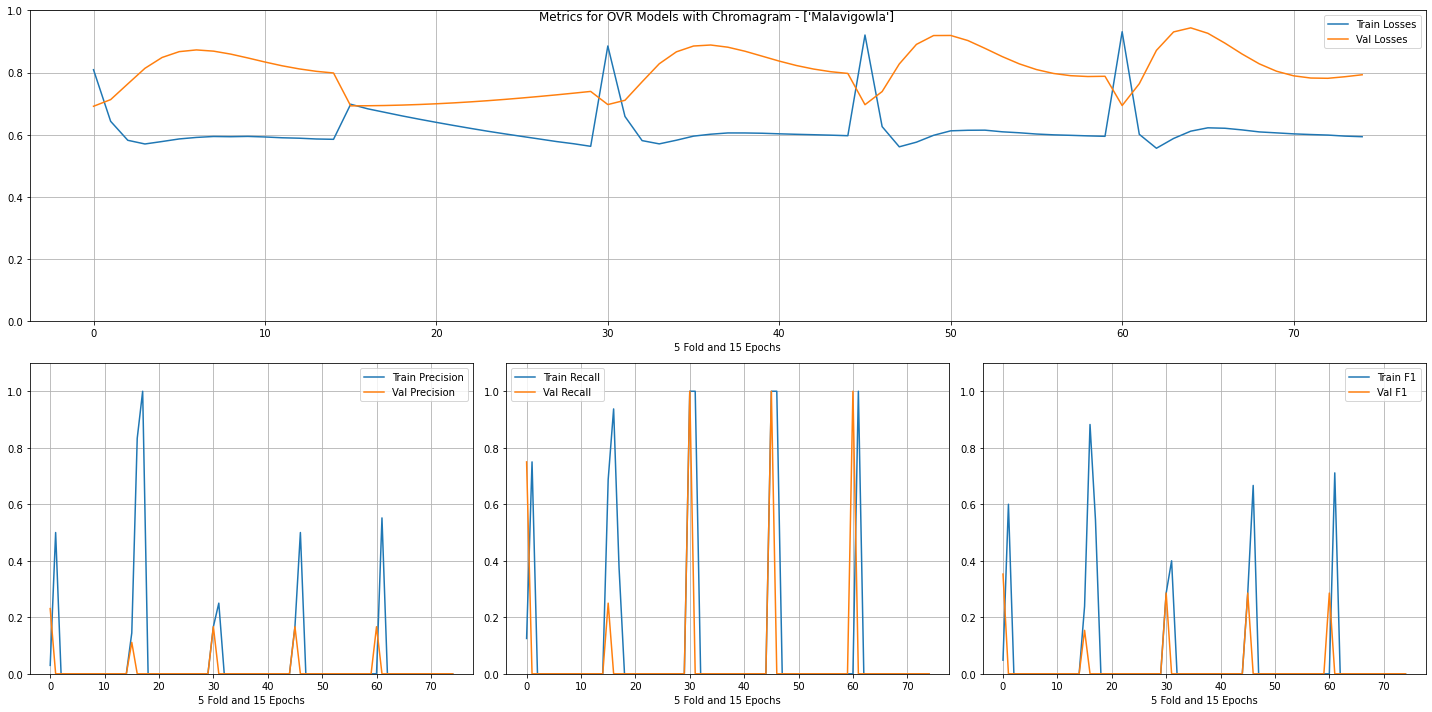

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.048193       0.352941  ...      0.809072           0.691537
0   0.285714       0.285714  ...      0.885521           0.696999
0   0.285714       0.285714  ...      0.920799           0.696664
0   0.000000       0.285714  ...      0.931365           0.693869
0   0.239130       0.153846  ...      0.698056           0.692850
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.602738           0.789556
11  0.000000       0.000000  ...      0.600612           0.782385
12  0.000000       0.000000  ...      0.598875           0.781533
13  0.000000       0.000000  ...      0.595513           0.786622
14  0.000000       0.000000  ...      0.593635           0.792919

[75 rows x 12 columns]
Training for ['Mukhari'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.809 / Validation Loss : 0.696 [Time :

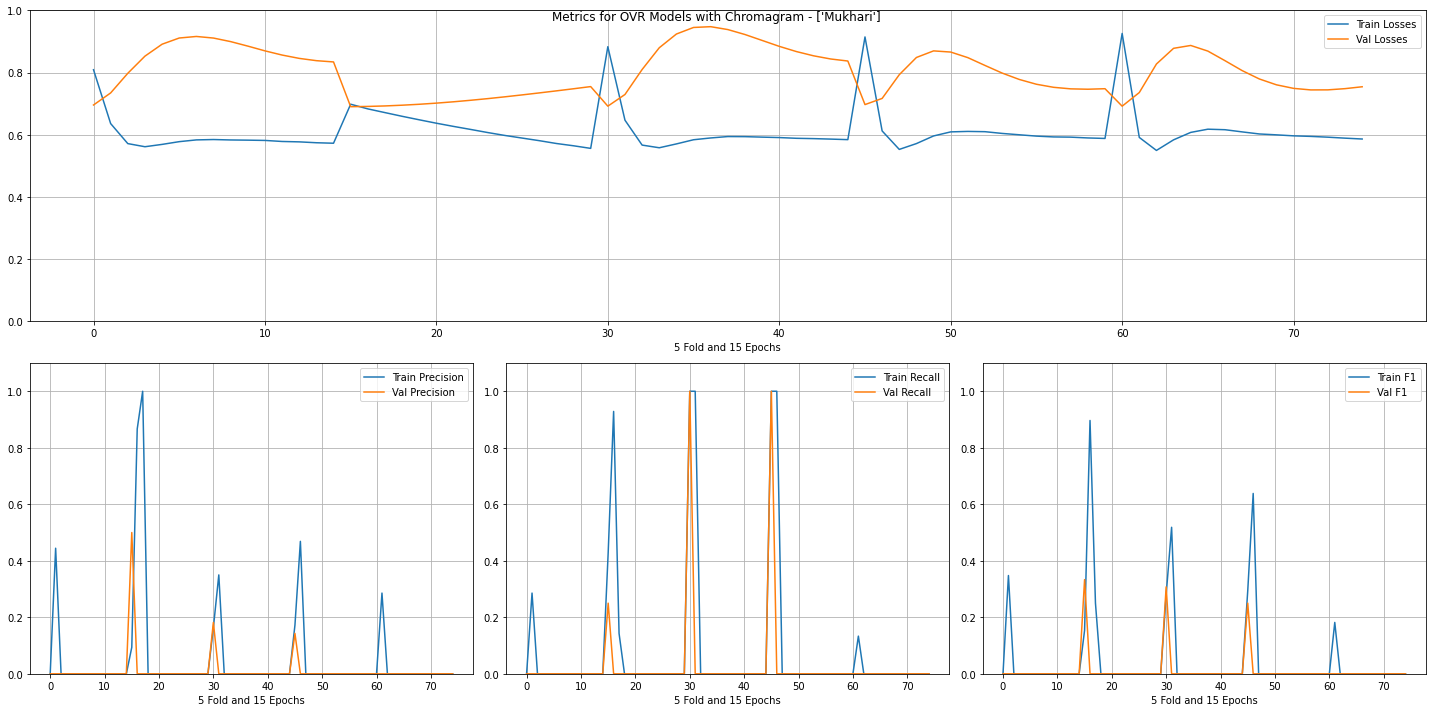

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.153846       0.333333  ...      0.698173           0.690171
0   0.280000       0.307692  ...      0.883222           0.691893
0   0.294118       0.250000  ...      0.914612           0.696966
1   0.896552       0.000000  ...      0.683136           0.691023
1   0.638298       0.000000  ...      0.612159           0.716752
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.596365           0.749122
11  0.000000       0.000000  ...      0.594621           0.744168
12  0.000000       0.000000  ...      0.592088           0.744329
13  0.000000       0.000000  ...      0.588949           0.748240
14  0.000000       0.000000  ...      0.586197           0.754304

[75 rows x 12 columns]
Training for ['Naata'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.803 / Validation Loss : 0.693 [Time : 0

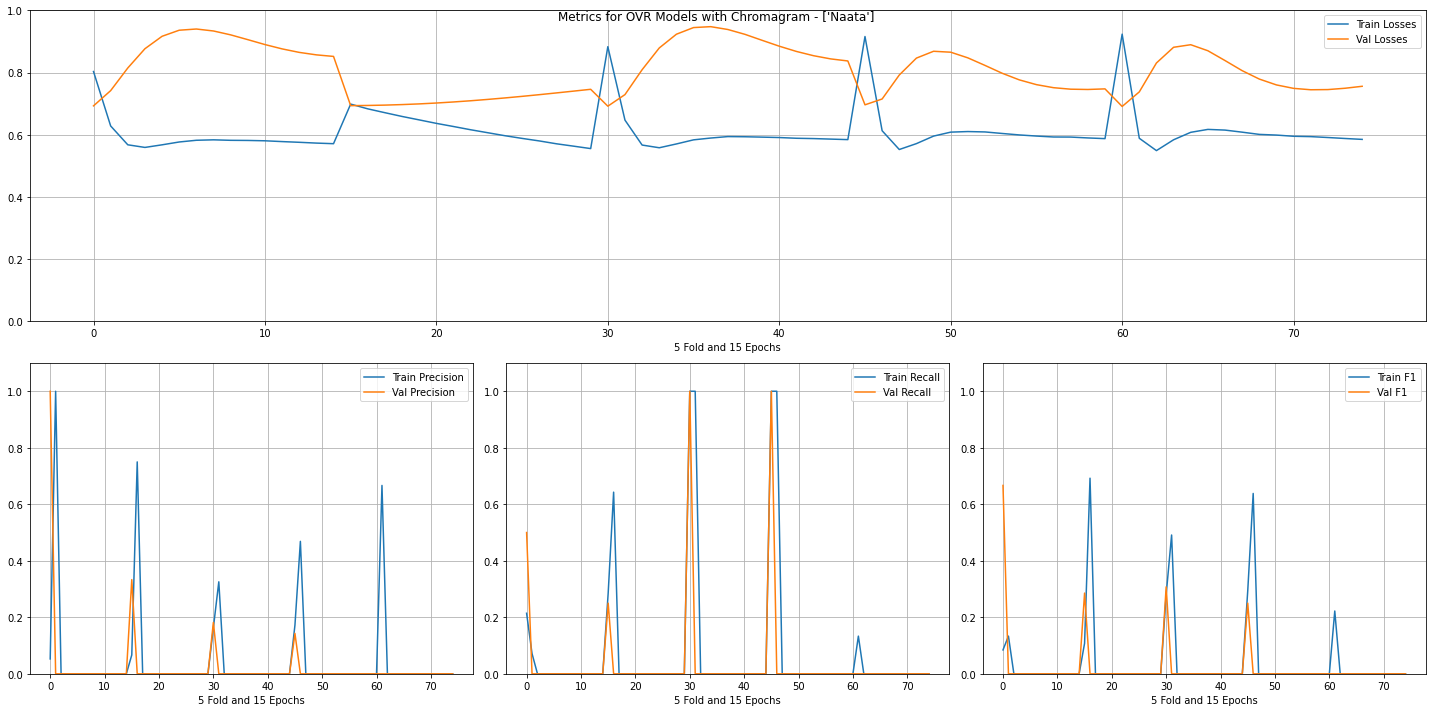

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.084507       0.666667  ...      0.803277           0.692826
0   0.280000       0.307692  ...      0.883255           0.691824
0   0.108108       0.285714  ...      0.698555           0.693532
0   0.294118       0.250000  ...      0.915925           0.696185
1   0.692308       0.000000  ...      0.683222           0.694165
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.595005           0.749142
11  0.000000       0.000000  ...      0.593877           0.744669
12  0.000000       0.000000  ...      0.591026           0.745246
13  0.000000       0.000000  ...      0.587883           0.749510
14  0.000000       0.000000  ...      0.584983           0.755823

[75 rows x 12 columns]
Training for ['Nadaramakriya'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 264/66
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.800 / Validation Loss : 0.576 

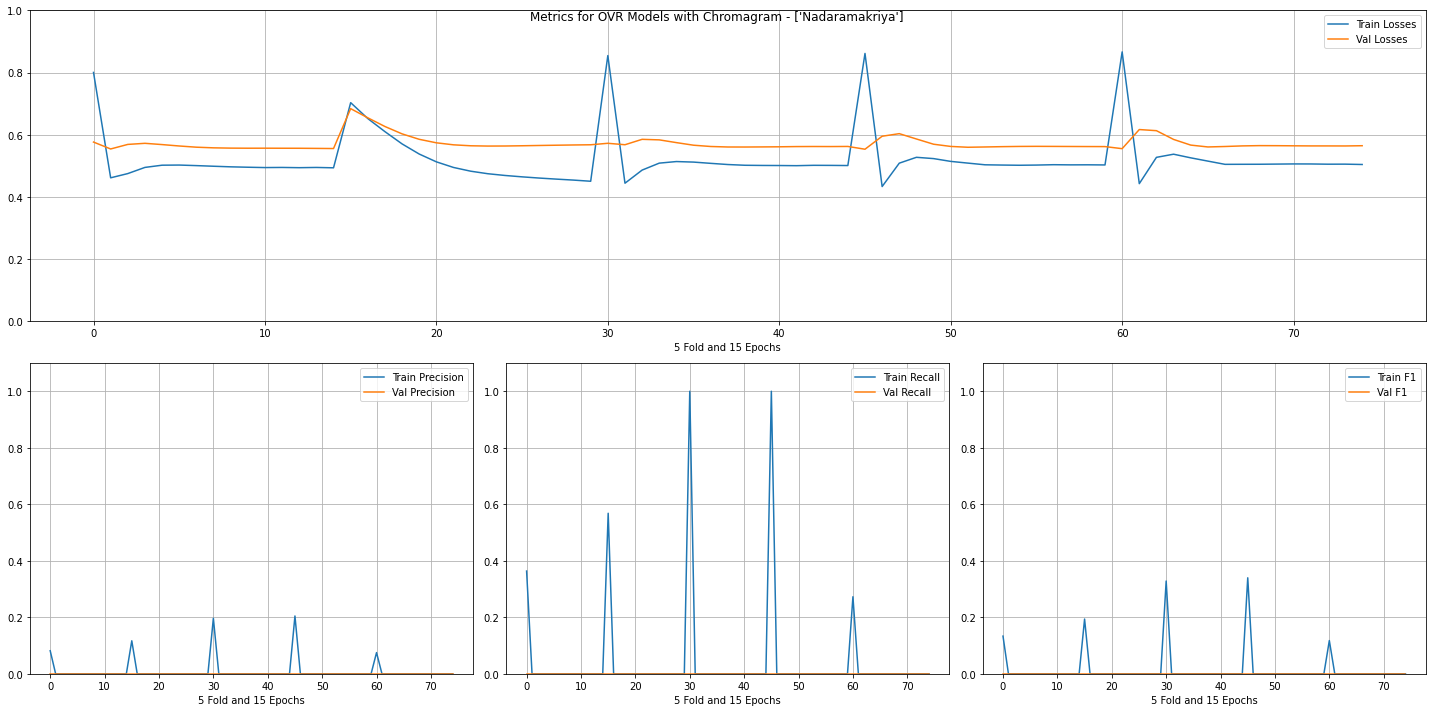

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.339768            0.0  ...      0.861502           0.553338
0   0.328358            0.0  ...      0.854605           0.572412
0   0.193798            0.0  ...      0.703151           0.683916
0   0.133333            0.0  ...      0.800369           0.576373
0   0.117647            0.0  ...      0.866516           0.555122
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.506004           0.564335
11  0.000000            0.0  ...      0.505891           0.563999
12  0.000000            0.0  ...      0.505161           0.563965
13  0.000000            0.0  ...      0.505304           0.563832
14  0.000000            0.0  ...      0.504205           0.564631

[75 rows x 12 columns]
Training for ['Paadi'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 292/74
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.786 / Validation Loss : 0.579 [Time : 

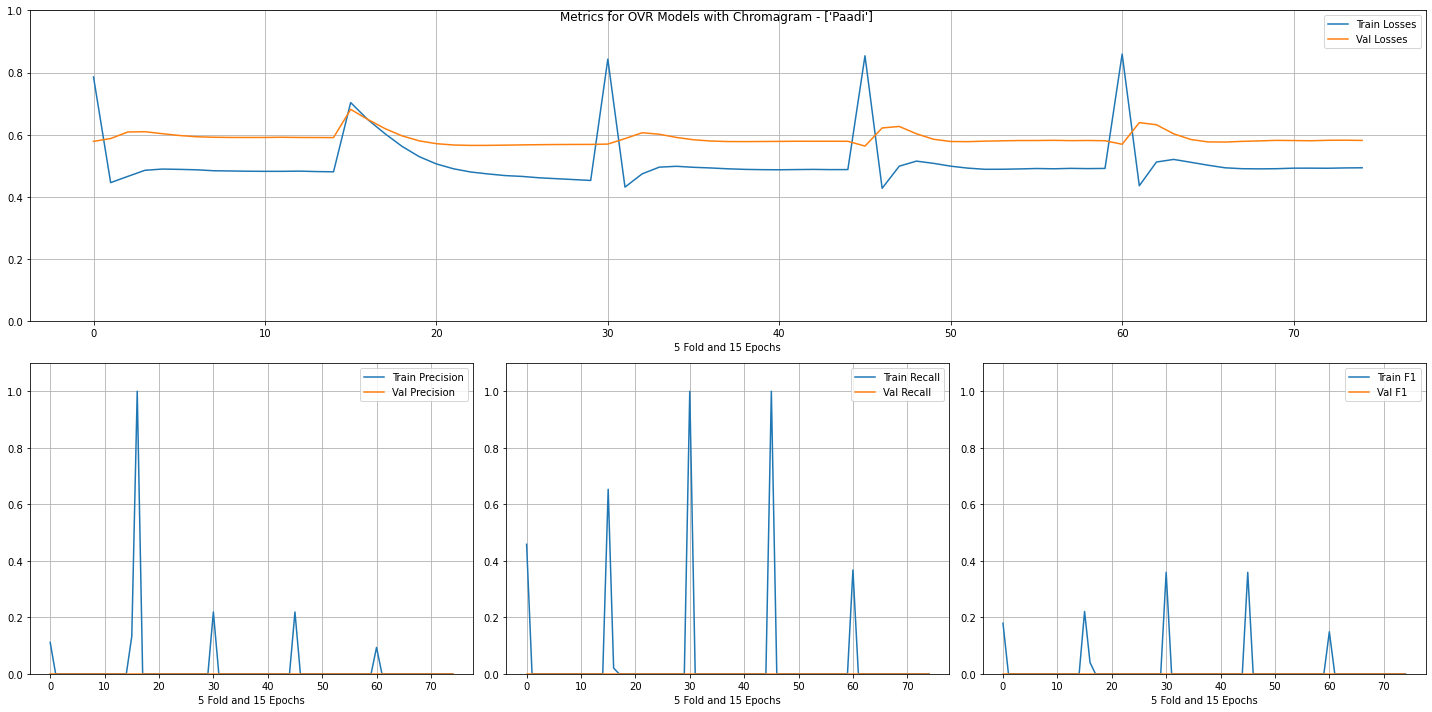

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.358974            0.0  ...      0.843211           0.569907
0   0.358974            0.0  ...      0.853955           0.563421
0   0.220690            0.0  ...      0.703420           0.681528
0   0.178862            0.0  ...      0.785742           0.578563
0   0.148760            0.0  ...      0.859556           0.569359
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.492390           0.581242
11  0.000000            0.0  ...      0.492437           0.580596
12  0.000000            0.0  ...      0.492139           0.582013
13  0.000000            0.0  ...      0.493200           0.582379
14  0.000000            0.0  ...      0.493600           0.581604

[75 rows x 12 columns]
Training for ['Ramakriya'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 470/118
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.798 / Validation Loss : 0.533 [Ti

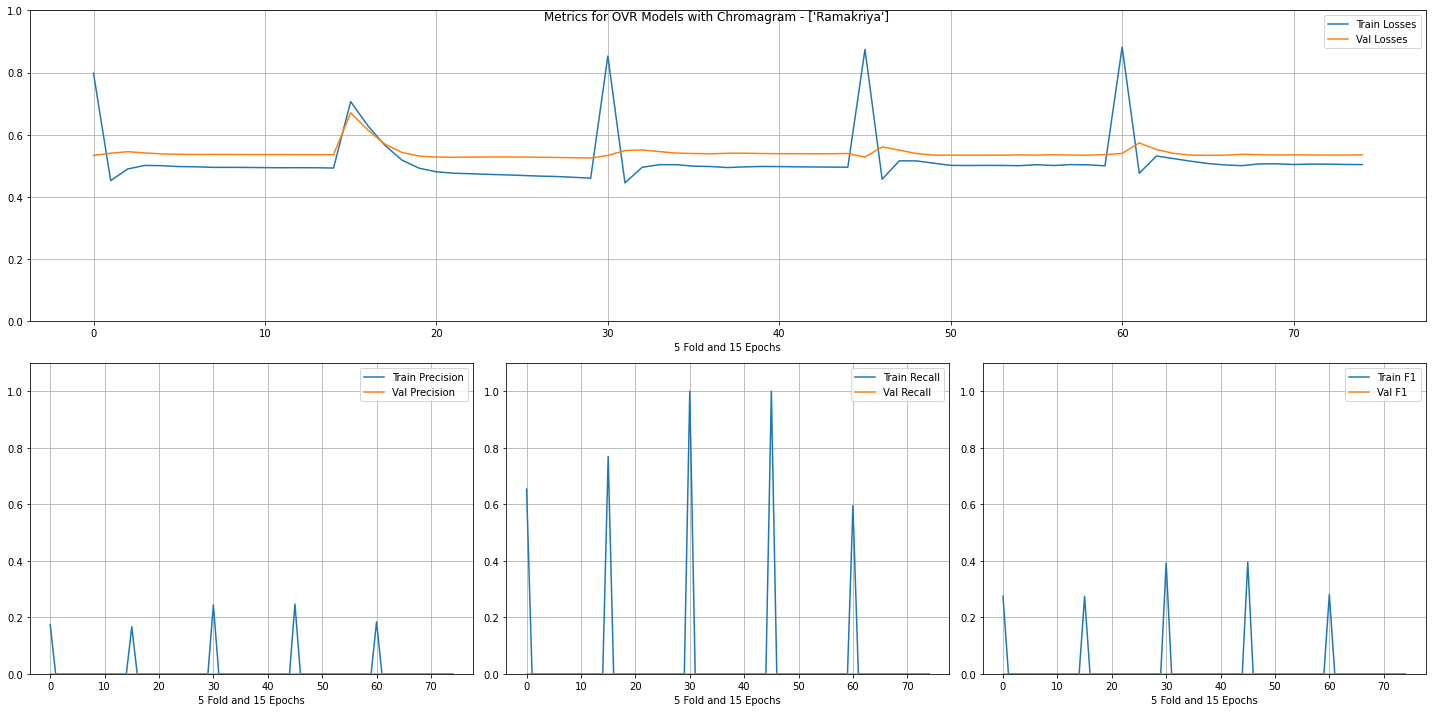

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.395990            0.0  ...      0.874621           0.528060
0   0.391960            0.0  ...      0.853170           0.533265
0   0.280597            0.0  ...      0.882270           0.539855
0   0.274933            0.0  ...      0.797979           0.533319
0   0.273973            0.0  ...      0.706403           0.670661
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.504184           0.535427
11  0.000000            0.0  ...      0.505414           0.534900
12  0.000000            0.0  ...      0.505274           0.534628
13  0.000000            0.0  ...      0.504383           0.534560
14  0.000000            0.0  ...      0.503929           0.535273

[75 rows x 12 columns]
Training for ['Salangam'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 105/27
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.782 / Validation Loss : 0.710 [Time

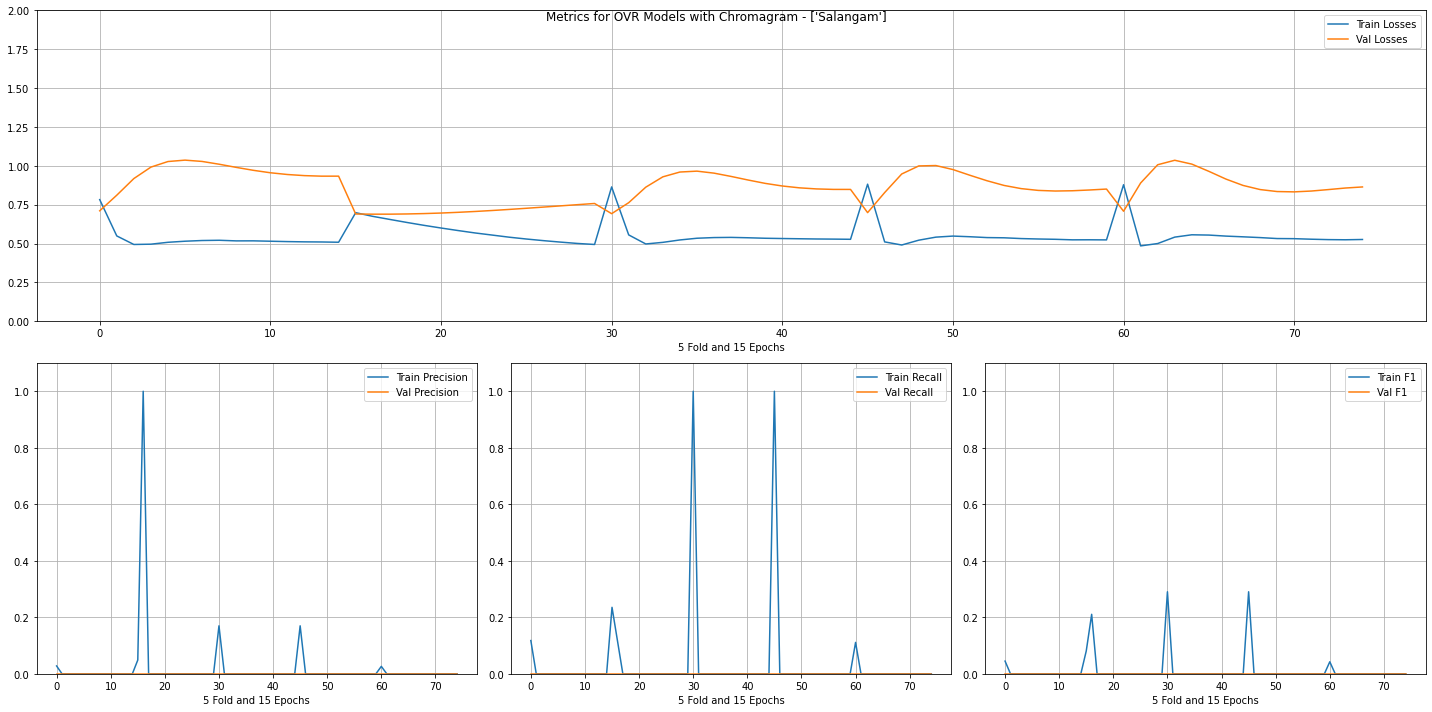

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.290323            0.0  ...      0.864120           0.691962
0   0.290323            0.0  ...      0.881711           0.698632
1   0.210526            0.0  ...      0.674699           0.688680
0   0.080808            0.0  ...      0.698338           0.689856
0   0.044944            0.0  ...      0.782305           0.710448
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.531093           0.832244
11  0.000000            0.0  ...      0.527605           0.837567
12  0.000000            0.0  ...      0.524987           0.846952
13  0.000000            0.0  ...      0.523975           0.856985
14  0.000000            0.0  ...      0.525827           0.863906

[75 rows x 12 columns]
Training for ['Salanganata'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 326/82
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.768 / Validation Loss : 0.577 [T

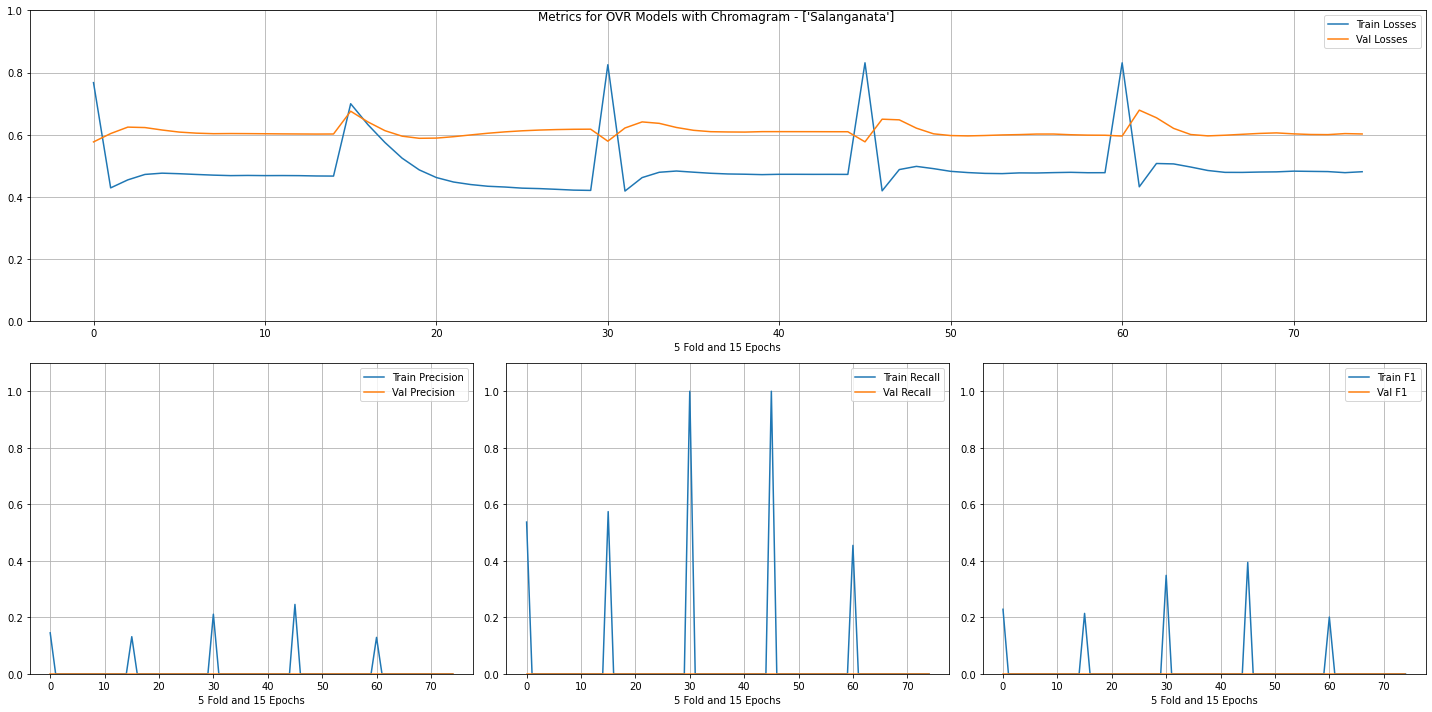

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.394265            0.0  ...      0.831407           0.577091
0   0.348387            0.0  ...      0.825182           0.579142
0   0.228346            0.0  ...      0.767584           0.576854
0   0.213793            0.0  ...      0.699699           0.675647
0   0.200803            0.0  ...      0.831307           0.595741
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.482780           0.602753
11  0.000000            0.0  ...      0.482044           0.600720
12  0.000000            0.0  ...      0.481384           0.600306
13  0.000000            0.0  ...      0.477934           0.603614
14  0.000000            0.0  ...      0.480952           0.602428

[75 rows x 12 columns]
Training for ['Samantham'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 158/40
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.772 / Validation Loss : 0.633 [Tim

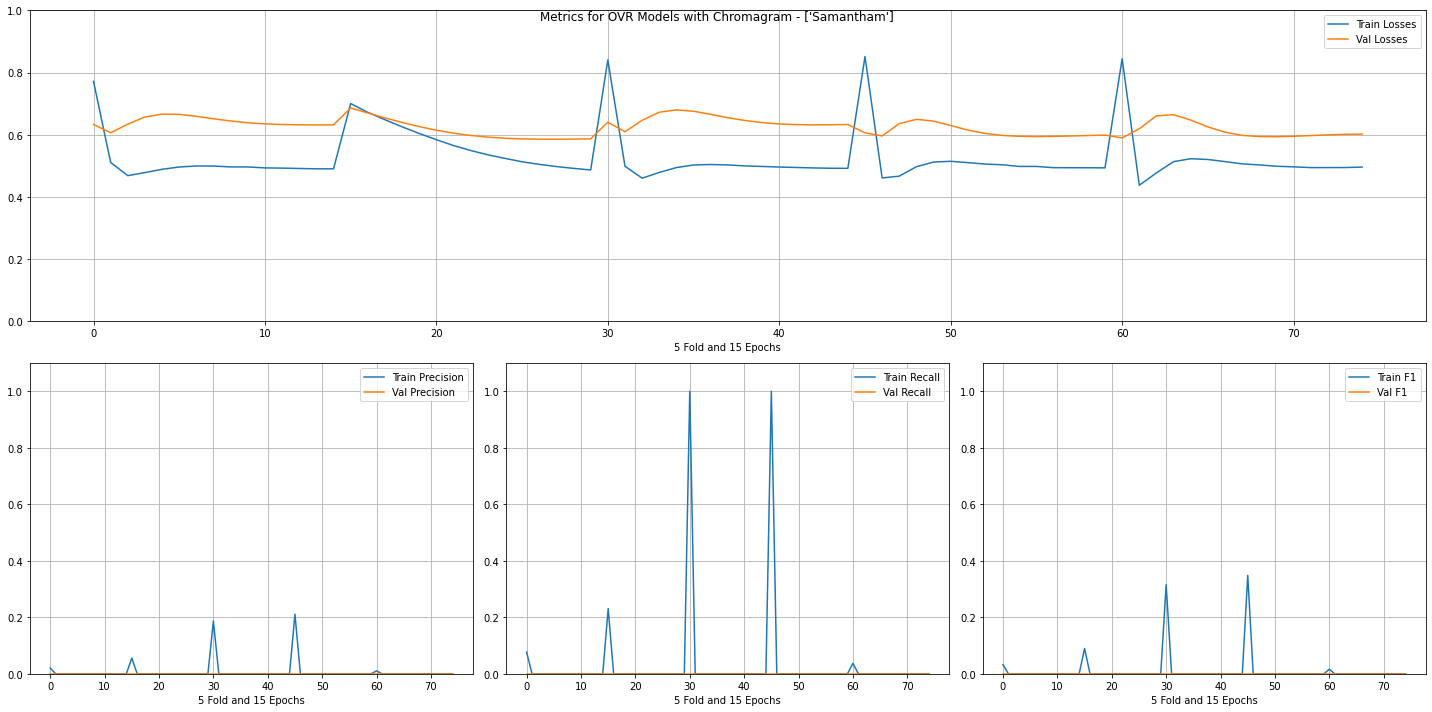

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.348387            0.0  ...      0.851585           0.606014
0   0.315152            0.0  ...      0.840879           0.640210
0   0.089552            0.0  ...      0.700246           0.686187
0   0.032258            0.0  ...      0.771859           0.633091
0   0.016129            0.0  ...      0.844607           0.589659
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.496658           0.595013
11  0.000000            0.0  ...      0.494172           0.597292
12  0.000000            0.0  ...      0.494280           0.599569
13  0.000000            0.0  ...      0.494387           0.601240
14  0.000000            0.0  ...      0.495873           0.602003

[75 rows x 12 columns]
Training for ['Sankarabharanam'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 312/78
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.801 / Validation Loss : 0.58

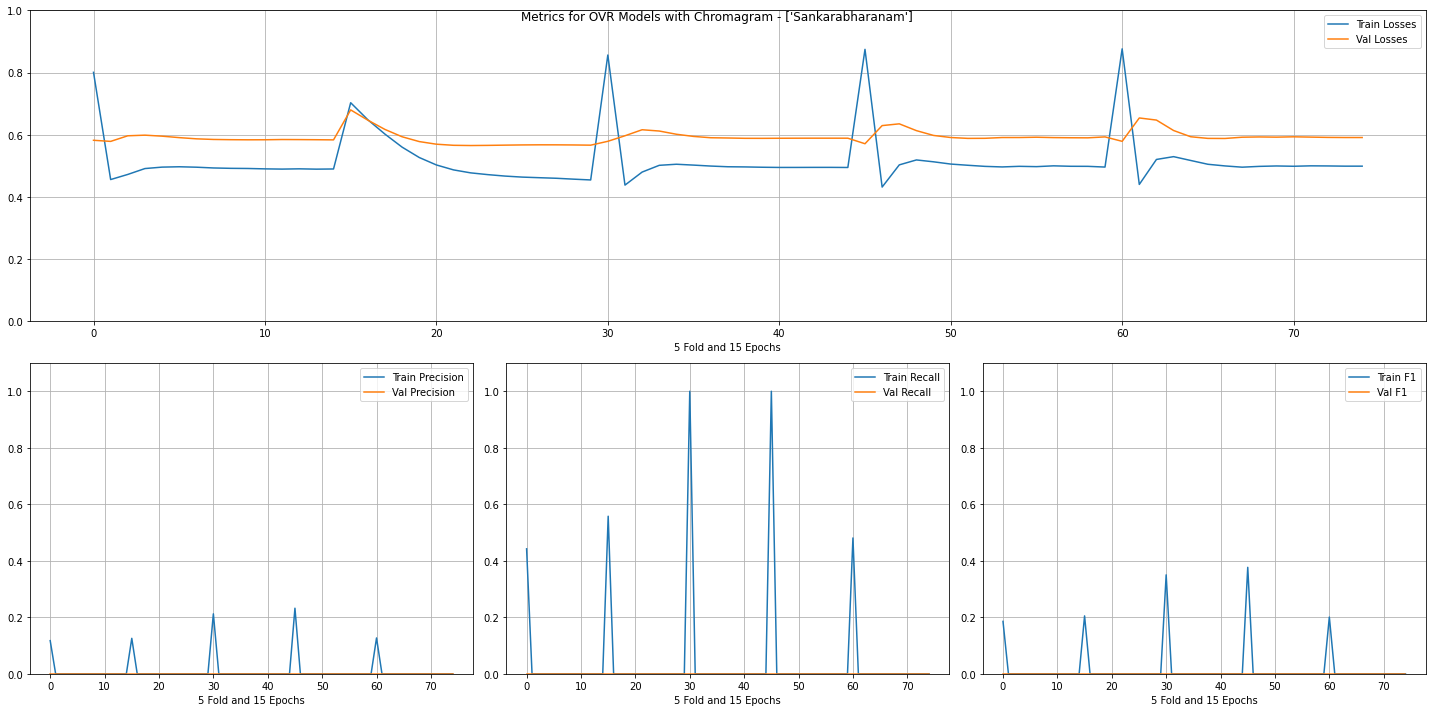

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.376812            0.0  ...      0.874666           0.570986
0   0.350168            0.0  ...      0.856450           0.578821
0   0.204947            0.0  ...      0.702955           0.679864
0   0.200803            0.0  ...      0.876321           0.578752
0   0.185484            0.0  ...      0.800691           0.582119
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.498520           0.593254
11  0.000000            0.0  ...      0.499877           0.592328
12  0.000000            0.0  ...      0.499516           0.591378
13  0.000000            0.0  ...      0.498844           0.591008
14  0.000000            0.0  ...      0.498848           0.590976

[75 rows x 12 columns]
Training for ['Sriragam'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 427/107
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.783 / Validation Loss : 0.530 [Tim

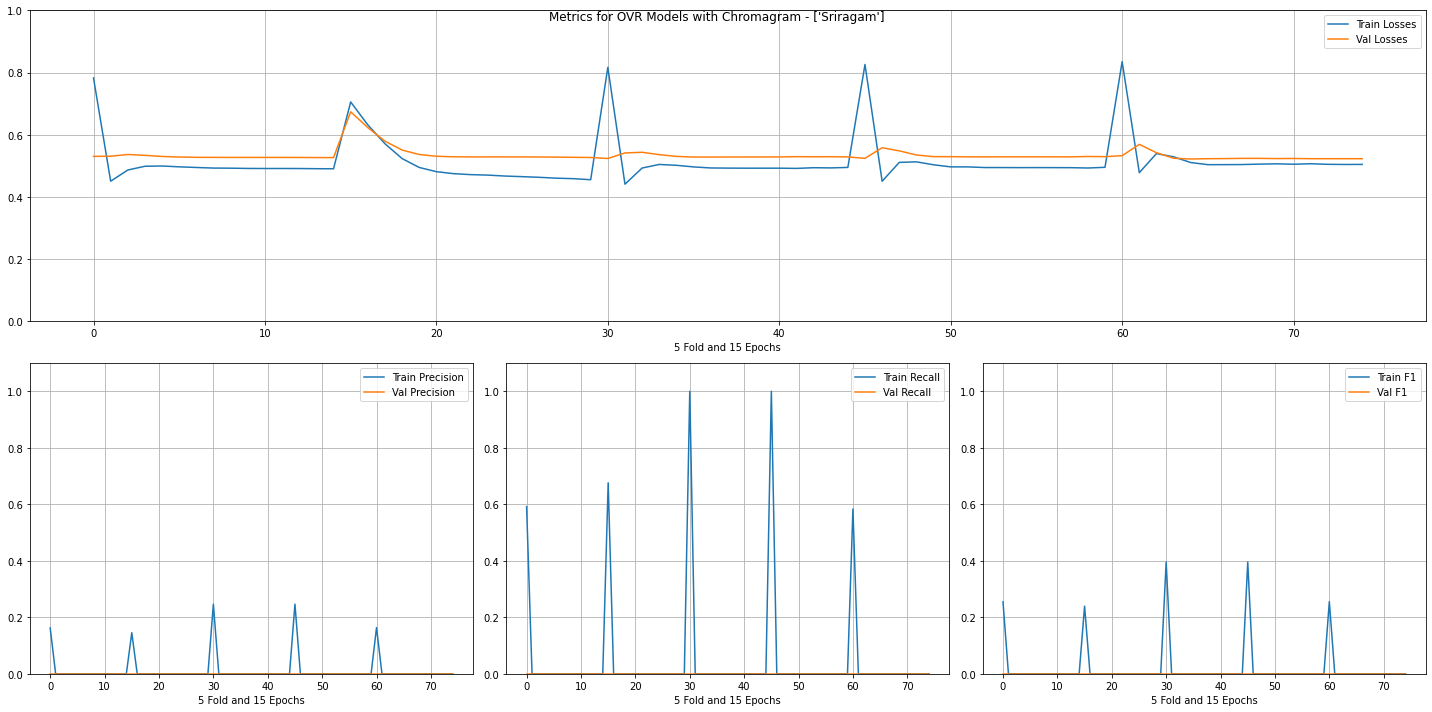

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.395543            0.0  ...      0.816747           0.523503
0   0.395543            0.0  ...      0.825955           0.524005
0   0.255319            0.0  ...      0.835191           0.532585
0   0.254545            0.0  ...      0.782622           0.530269
0   0.239401            0.0  ...      0.705420           0.673773
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.505079           0.523562
11  0.000000            0.0  ...      0.506620           0.522867
12  0.000000            0.0  ...      0.504766           0.522851
13  0.000000            0.0  ...      0.504288           0.522879
14  0.000000            0.0  ...      0.504510           0.522827

[75 rows x 12 columns]
Training for ['Suddavasantham'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.790 / Validation Loss : 0.686 

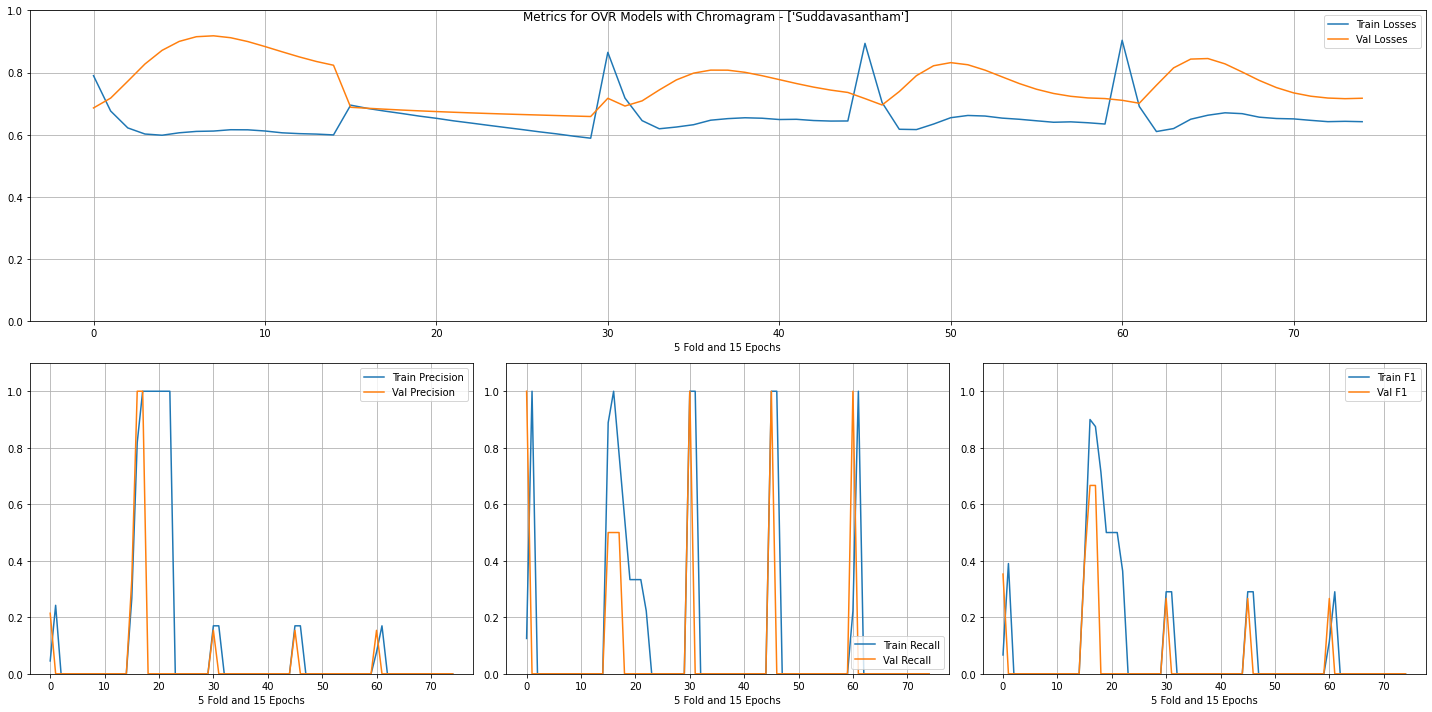

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.900000       0.666667  ...      0.684483           0.685083
2   0.875000       0.666667  ...      0.675885           0.682109
0   0.410256       0.400000  ...      0.695148           0.688291
0   0.066667       0.352941  ...      0.789911           0.686168
0   0.290323       0.266667  ...      0.865013           0.717226
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.650927           0.734616
11  0.000000       0.000000  ...      0.646232           0.723922
12  0.000000       0.000000  ...      0.642034           0.718009
13  0.000000       0.000000  ...      0.643109           0.715945
14  0.000000       0.000000  ...      0.641918           0.717352

[75 rows x 12 columns]
Training for ['Varali'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 451/113
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.782 / Validation Loss : 0.531 [Time 

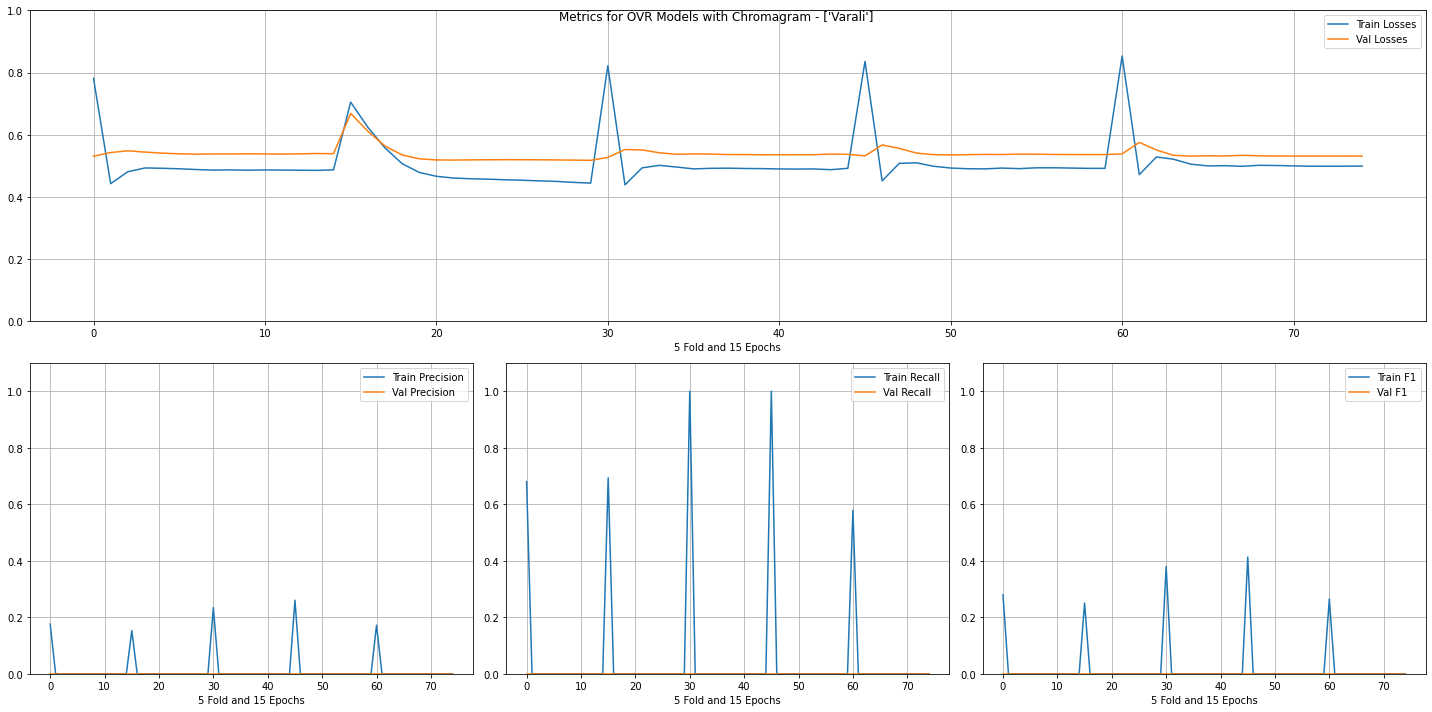

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.413223            0.0  ...      0.835776           0.531912
0   0.379747            0.0  ...      0.821768           0.526967
0   0.279452            0.0  ...      0.781589           0.530923
0   0.265060            0.0  ...      0.853478           0.538529
0   0.250602            0.0  ...      0.704894           0.668363
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.499736           0.531279
11  0.000000            0.0  ...      0.498567           0.531273
12  0.000000            0.0  ...      0.498713           0.531329
13  0.000000            0.0  ...      0.498680           0.531294
14  0.000000            0.0  ...      0.499191           0.531033

[75 rows x 12 columns]


In [10]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, ChromaMatrixDataset, ChromaRaga, "OVR Models with Chromagram", 
                          labels, le.classes_, lbl_encoder=le, lr=5e-5, epochs=15, n_folds=5, feature='chroma',nindex_factor=5)

In [12]:
tab = pd.DataFrame(columns=['Raga','Train Confusion','Test Confusion'] + list(ovr_res[list(ovr_res.keys())[0]][1].keys()))
idx = 0
nresults = 1
for r in ovr_res:
  # Get top "nresults"
  tmp = results_to_df(ovr_res[r]).head(nresults)
  for _ in range(nresults):
    tab.loc[idx,'Raga'] = le.inverse_transform([r])[0]
    for i in tmp.columns:
      tab.loc[idx,i] = tmp[i].tolist()[_]
    t = confusion_matrix(tab.loc[idx,'train_labels'][0],tab.loc[idx,'train_predictions'][0])
    tab.loc[idx,'Train Confusion'] = str(t[0]) + '\n' +str(t[1])
    t = confusion_matrix(tab.loc[idx,'validation_labels'][0],tab.loc[idx,'validation_predictions'][0])
    tab.loc[idx,'Test Confusion'] = str(t[0]) + '\n' +str(t[1])
    idx = idx + 1

In [13]:
from IPython.display import display, HTML
display( HTML( tab[['Raga','Train Confusion','Test Confusion','train_f1','validation_f1','train_precision','validation_precision','train_recall','validation_recall']].to_html().replace("\\n","<br>") ) )

,Raga,Train Confusion,Test Confusion,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
0,Aahiri,[ 56 124][ 0 36],[45 0][9 0],0.367347,0,0.225,0,1,0
1,Bauli,[16 44][11 1],[12 3][1 2],0.0350877,0.5,0.0222222,0.4,0.0833333,0.666667
2,Bauliramakriya,[15 61][14 1],[13 6][1 3],0.025974,0.461538,0.016129,0.333333,0.0666667,0.75
3,Bhairavi,[112 0][18 4],[28 0][6 0],0.307692,0,1,0,0.181818,0
4,Bhupalam,[16 44][4 8],[14 1][1 2],0.25,0.666667,0.153846,0.666667,0.666667,0.666667
5,Desakshi,[20 36][7 4],[14 0][1 2],0.156863,0.8,0.1,1,0.363636,0.666667
6,Desalam,[ 40 100][ 0 28],[35 0][7 0],0.358974,0,0.21875,0,1,0
7,Devagandhari,[ 11 105][ 0 23],[29 0][6 0],0.304636,0,0.179688,0,1,0
8,Dhannasi,[64 96][ 0 32],[40 0][8 0],0.4,0,0.25,0,1,0
9,Gowla,[14 66][13 3],[ 4 16][0 4],0.0705882,0.333333,0.0434783,0.2,0.1875,1


In [14]:
tab.index = tab['Raga']

In [15]:
def bar_plot(df, cols, title):
  df[cols].plot.bar(figsize=[20,5],grid=True)
  plt.title(title)
  plt.legend(['Train','Validation'])
  plt.xticks(rotation=45)
  plt.show()

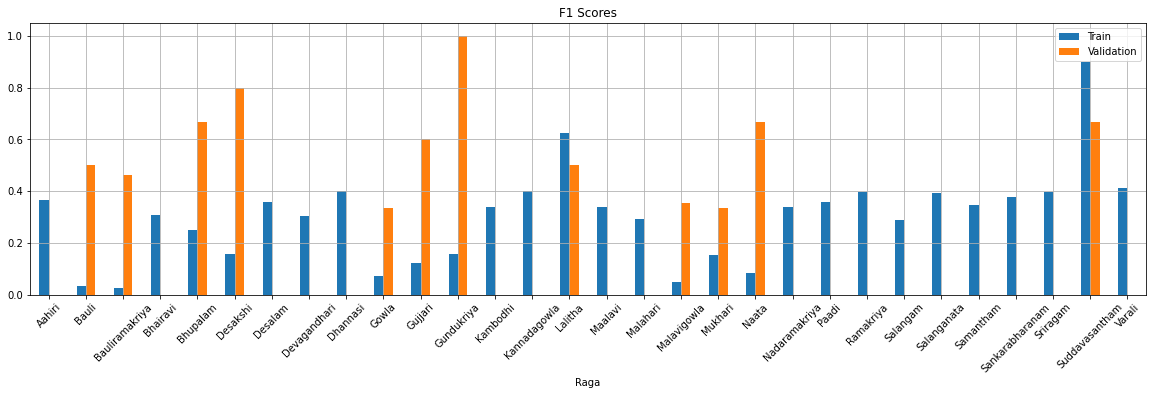

In [16]:
bar_plot(tab, ['train_f1','validation_f1'],'F1 Scores')

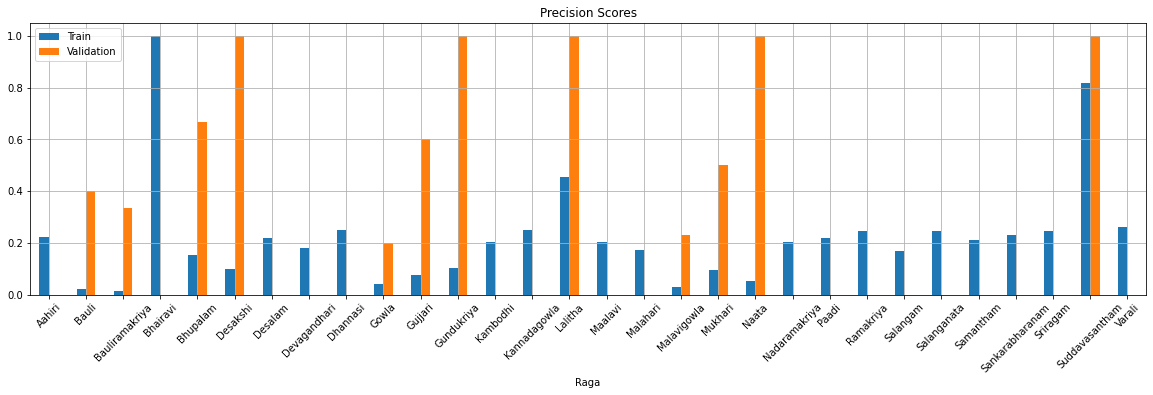

In [17]:
bar_plot(tab, ['train_precision','validation_precision'],'Precision Scores')

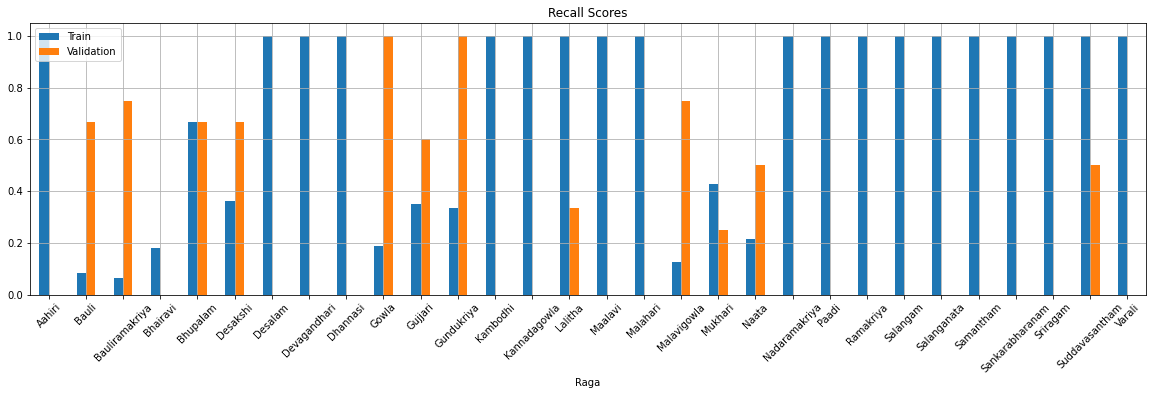

In [18]:
bar_plot(tab, ['train_recall','validation_recall'],'Recall Scores')